## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [294]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from scipy.stats import kurtosis
from scipy.stats import skew

import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


## 1. Exploratory data analysis

In [295]:
df_credit = pd.read_csv('creditcard.csv')
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [296]:
df_credit.shape  # (284807, 31)

(284807, 31)

In [297]:
# check the null values
df_credit_Null = (df_credit.isnull().sum(axis = 0)/df_credit.shape[0])*100
df_credit_Null[df_credit_Null>0].head()

Series([], dtype: float64)

### Checking the Fraud Rate

### 1.1 Here we will observe the distribution of our classes and Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations.

In [298]:
#observe the different feature type present in the data and find the fraud_rate(which is 0.172749)
classes = df_credit['Class'].value_counts()*100/df_credit.shape[0]
print(classes)

0    99.827251
1     0.172749
Name: Class, dtype: float64


Text(0.5, 1.0, 'Plotting data for the fraud: ')

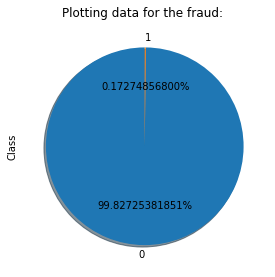

In [299]:
fig = plt.figure(figsize=(13,10))

ax1 = plt.subplot(221)
df_credit['Class'].value_counts().plot.pie(autopct = "%1.11f%%", ax=ax1, shadow=True, startangle=90)
plt.title('Plotting data for the fraud: ')

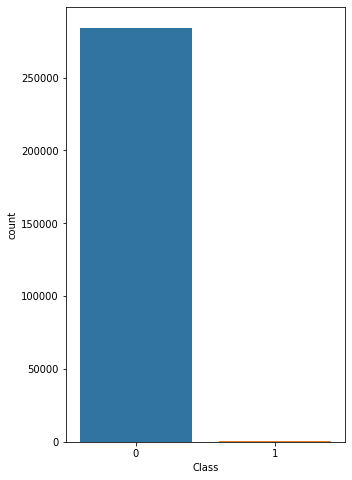

In [300]:
#Plot the different class counts. We can clearly see the data imbalance. frauds are in minority. 
plt.figure(figsize=(5,8))
sns.countplot(x="Class", data=df_credit)
plt.show()

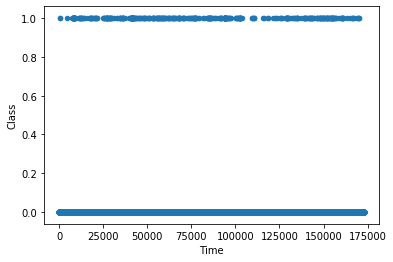

In [301]:
# Create a scatter plot to observe the distribution of classes with time
df_credit.plot.scatter(x='Time',y='Class')

 From the above scatter plot between the Class and Time indicates a the fraudulent transactions have 
 happened throughout the given time frame there are no fixed time patterns followed by these fraudulent 
 transactions indicating that the `Time` feature is NOT an important feature in our dataframe hence can be removed.

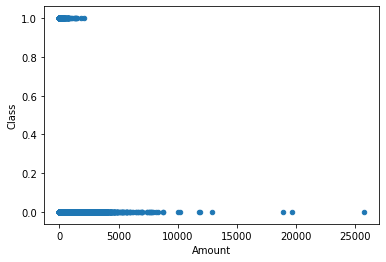

In [302]:
# Create a scatter plot to observe the distribution of classes with Amount
df_credit.plot.scatter(x='Amount',y='Class')
#sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)

Class 0 (non fraudulent) transactions have happened for the amounts ranging 0 - 25000 Euros 
(Considering the dataset is of transactions of European Card Holders). 
When we can observe that transactions more than say, 15000 as outliers, most of the non-fraudulent transactions
are in range of 0 to 10000. 

Class 1 (fraudulent transactions) have happened only for smaller amounts 0 to 5000 Euros. 
This might be because of the fact that there is increased chance of higher value transactions to be 
constantly reviewed.

In [303]:
# Drop unnecessary columns. As Time column is not adding any value
df_credit.drop(['Time'], axis=1, inplace = True)

### Outlier removal


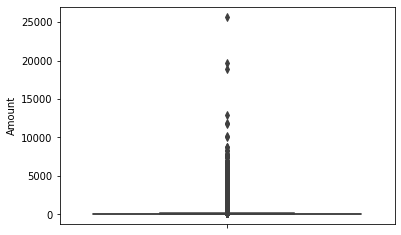

In [304]:
# plot the amount variable
sns.boxplot(y=df_credit['Amount'])
plt.show()

From the Boxplot we could see there are some outliers present. we think 10,000 might be good cap. 
To concrete this, let us check how many transactions have happened in these two days for amount 
value greater than or equal to 10,000.

In [305]:
df_credit.loc[df_credit['Amount']>=10000]['Amount'].count()

8

There are only 8 records with transaction amount greater than or equal to 10,000 Euros. 
We will go ahead and remove these records.

In [306]:
#Before removing the records
df_credit.shape

(284807, 30)

In [307]:
# Drop the records
df_credit = df_credit.loc[df_credit['Amount']<10000]

#After removing the records
df_credit.shape

(284799, 30)

Text(0.5, 1.0, 'Amount distribution for fraudulent transactions')

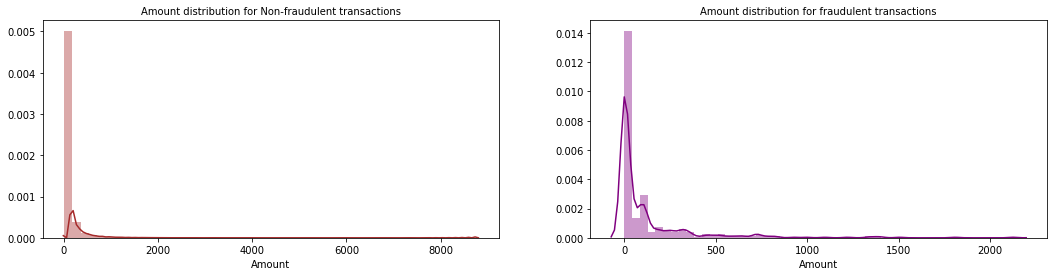

In [308]:
# plot the distribution of amount for 2 different class
fig, ax = plt.subplots(1, 2, figsize=(18,4))

#plt.subplot(121)
sns.distplot(df_credit[df_credit['Class']==0]['Amount'],bins=50, ax=ax[0], color='brown')
ax[0].set_title('Amount distribution for Non-fraudulent transactions', fontsize=10)

#plt.subplot(122)
sns.distplot(df_credit[df_credit['Class']==1]['Amount'],bins=50, ax=ax[1], color='purple')
ax[1].set_title('Amount distribution for fraudulent transactions', fontsize=10)

from the above graph it can be observed that some transactions are of 0 amount in both the categories.

In [309]:
#Finding the Min-Max values for fraudulent and valid transactions after the Outlier Removal.
print('Min amount for a fraudulent transaction:', df_credit[df_credit['Class']==1]['Amount'].min())
print('Max amount for a fraudulent transaction:', df_credit[df_credit['Class']==1]['Amount'].max())
print('Min amount for a valid transaction:', df_credit[df_credit['Class']==0]['Amount'].min())
print('Max amount for a valid transaction:', df_credit[df_credit['Class']==0]['Amount'].max())

print('No of transactions where amount is 0 for fraudulent transactions:', 
      df_credit[(df_credit['Class']==1) & (df_credit['Amount']==0)].shape[0])
print('No of transactions where amount is 0 for valid transactions:', 
      df_credit[(df_credit['Class']==0) & (df_credit['Amount']==0)].shape[0])

Min amount for a fraudulent transaction: 0.0
Max amount for a fraudulent transaction: 2125.87
Min amount for a valid transaction: 0.0
Max amount for a valid transaction: 8790.26
No of transactions where amount is 0 for fraudulent transactions: 27
No of transactions where amount is 0 for valid transactions: 1798


We can see 27 transactions which is fraudulent but amount is 0.
<font color='red'>Need to see what exactly this means and reason why someone would a $0 transaction</font>

### <font color='red'>Reusable plotting functions:</font> Defining some help functions useful for plotting later

In [310]:
# Defining a function that can be useful for box plot
def pltBox(subpltnum,xCol,yCol,dfObj,hueCol=None):
    if ',' in str(subpltnum):
        nums=str(subpltnum).split(',')
        plt.subplot(int(nums[0]),int(nums[1]),int(nums[2]))
    else:
        plt.subplot(subpltnum)
    if hueCol==None:
        sns.boxplot(x=xCol,y=yCol,data=dfObj)
    else:
        sns.boxplot(x=xCol,y=yCol,data=dfObj,hue=hueCol)

### Plot the distribution of data for skewness and kurtosis analysis

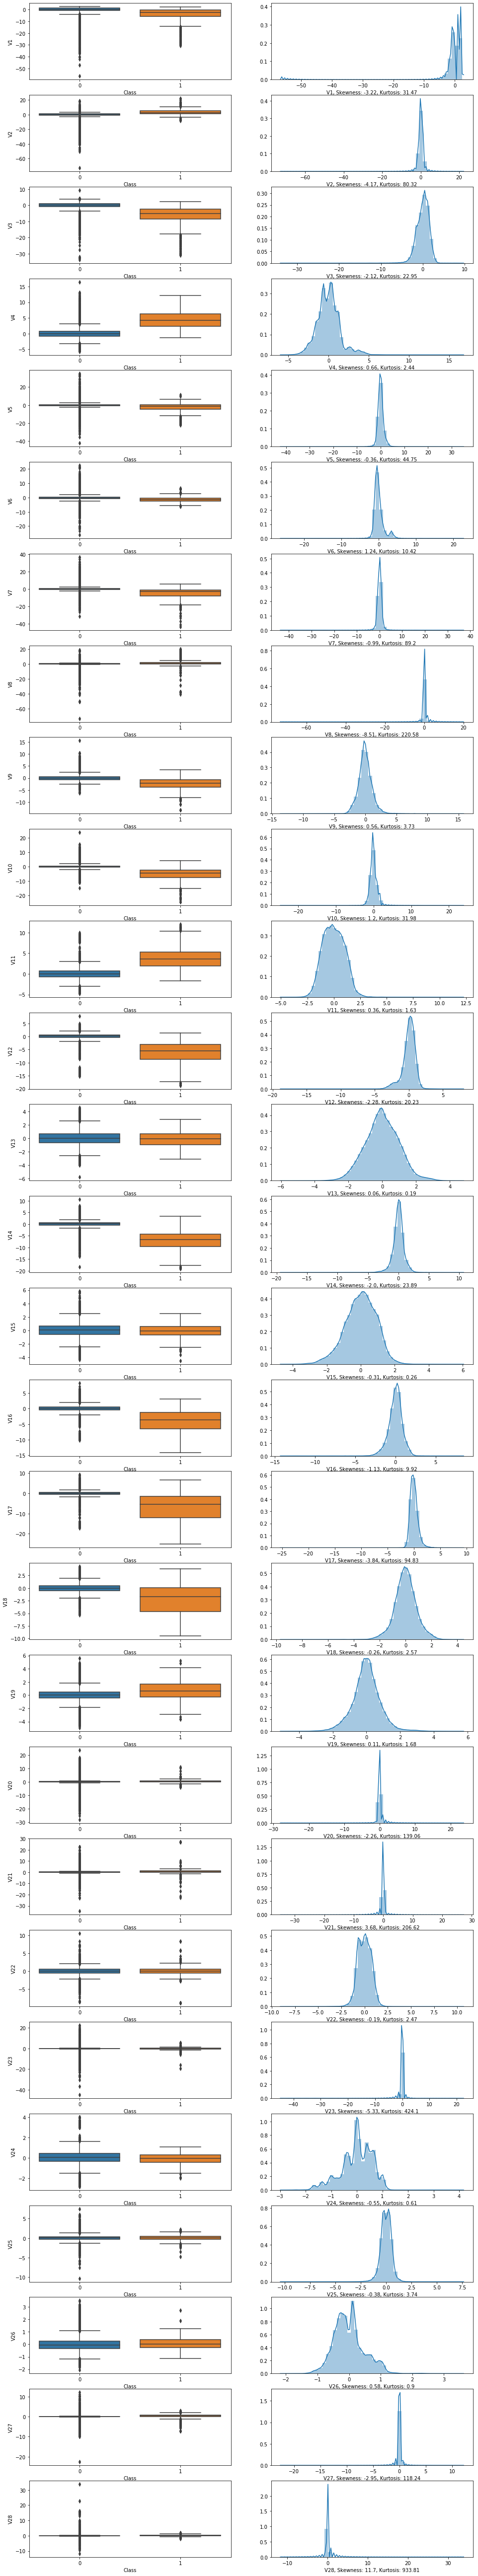

In [311]:
### plot the histogram of a variable from the dataset to see the skewness

plt.figure(figsize=(16,98))

subplotNum = "29,2,"
pltNum = 1
colNumSuf = 1

for i in range(0,28):  # As we have 29 PCA columns lets plot all the columnes and chk the skewness.
    col = "V" + str(colNumSuf)
    colNumSuf = colNumSuf + 1
    
    pltNo = subplotNum + str(pltNum)
    pltBox(pltNo,'Class',col,df_credit)
    
    pltNum = pltNum + 1

    plt.subplot(29,2,pltNum)
    sns.distplot(df_credit[col],bins=50)
    plt.xlabel(col + ', Skewness: ' + str(np.round(skew(df_credit[col]),2)) + ', Kurtosis: ' + str(np.round(kurtosis(df_credit[col]),2)))
    
    pltNum = pltNum + 1

In [312]:
# Create a ckew summary dataframe
df_credit_Skew_Summary = pd.DataFrame(df_credit.columns.to_list(), columns =['Variables'])

df_credit_Skew_Summary['min'] = -100000   # Assign some default value
df_credit_Skew_Summary['max'] = -100000    # Assign some default value
df_credit_Skew_Summary['skew'] = -100000   # Assign some default value
df_credit_Skew_Summary['kurtosis'] = -100000  # Assign some default value

for col in df_credit.columns.to_list():
    df_credit_Skew_Summary.loc[df_credit_Skew_Summary.Variables == col,'min'] = np.round(df_credit[col].min())
    df_credit_Skew_Summary.loc[df_credit_Skew_Summary.Variables == col,'max'] = np.round(df_credit[col].max())
    df_credit_Skew_Summary.loc[df_credit_Skew_Summary.Variables == col,'skew'] = np.round(skew(df_credit[col]),2)
    df_credit_Skew_Summary.loc[df_credit_Skew_Summary.Variables == col,'kurtosis'] = np.round(kurtosis(df_credit[col]),2)

In [313]:
df_credit_Skew_Summary

,Variables,min,max,skew,kurtosis
0,V1,-56.0,2.0,-3.22,31.47
1,V2,-73.0,22.0,-4.17,80.32
2,V3,-34.0,9.0,-2.12,22.95
3,V4,-6.0,16.0,0.66,2.44
4,V5,-42.0,35.0,-0.36,44.75
5,V6,-26.0,23.0,1.24,10.42
6,V7,-44.0,37.0,-0.99,89.20
7,V8,-73.0,20.0,-8.51,220.58
8,V9,-13.0,16.0,0.56,3.73
9,V10,-25.0,24.0,1.20,31.98


#####   Lower Bound.           Upper Bound.           Result
#####        x < -1.0       ,          x > +1.0          ,        Highly Skewed
#####    -0.5 < x < -1.0  ,        0.5 < x < 1.0         , moderatly Skewed
#####     -0.5 < x < 0.5   ,       -0.5 < x < 0.5        , Apropriatly symmetric

df_credit_Skew_Summary shows all the variables in our dataframe along with their min,max values and skewness and kurtosis values. We cann see some of the variables are highly skewed which needs to be mitigated. <br>
Hence we can go ahead with the Power Transfomer function which can be used to normlise the data and mitigate skewness.
We can either go wuth Box-Cox approach or Yeo Johnson for this. <br>
But Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data, hence we can go ahead with this. <br>
The Amount feature alone we can apply StandardScaling as discussed above.

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

### 2. Splitting the data into train & test data

In [314]:
X = df_credit.drop(['Class'], axis=1)
y= df_credit['Class']#class variable

In [315]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, stratify=y)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [316]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


In [317]:
# standardization of only Amount feature is required
train_std = ['Amount']
scaler   = StandardScaler()
X_train[train_std] = scaler.fit_transform(X_train[train_std].values)
X_test[train_std] = scaler.transform(X_test[train_std].values)

### Skewness mitigation using yeo-johnson PowerTransformer method

In [318]:
# Name of the columns preserved for later use
train_yjt = X_train.columns
# scaling method: power tranformation
pt = PowerTransformer(method='yeo-johnson')

In [319]:
# power transform
X_train[train_yjt] = pt.fit_transform(X_train[train_yjt].values)
X_test[train_yjt] = pt.transform(X_test[train_yjt].values)

In [320]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
143129,-0.788546,0.902980,1.347512,0.727953,-0.175428,0.282119,0.256948,0.495997,-0.516017,-0.619850,...,0.209188,-0.211759,-0.386040,-0.190416,0.073060,0.747090,-0.748825,0.584978,0.266072,-0.173963
106044,-1.532724,2.970702,-0.691862,0.205467,-0.265019,-1.376878,1.068559,-0.492340,2.057146,4.197532,...,2.687684,-0.677183,0.937101,0.156251,1.667243,-0.470244,-1.450908,-0.452050,-4.028538,-1.046027
172599,0.705215,-0.772806,-1.420527,0.534085,-0.002650,-0.423785,0.463597,-0.318451,0.902031,-1.031710,...,0.839249,-0.022186,-1.003188,-0.222214,0.811019,-0.392866,-0.241441,-0.225414,0.180879,1.948107
122452,-0.692882,0.458590,0.476539,0.054077,0.691810,0.710407,-0.063981,-0.576926,-0.410228,0.247748,...,-0.046344,0.659869,-1.156005,0.359025,-1.957544,-0.620720,0.464985,0.647290,0.301255,-0.974311
207553,1.648699,-0.966792,-0.701524,-1.126065,-1.149938,-0.671728,-1.016396,-0.117085,-1.075372,1.609850,...,-0.775548,-0.174983,-0.034679,0.411769,-0.104274,-0.581408,-0.299584,-0.046943,-0.188137,-0.574153


In [321]:
X_train_Summary_pw = pd.DataFrame(X_train.columns.to_list(), columns =['Variables'])

In [322]:
X_train_Summary_pw['min'] = -100000
X_train_Summary_pw['max'] = -100000
X_train_Summary_pw['skew'] = -100000
X_train_Summary_pw['kurtosis'] = -100000

for col in X_train.columns.to_list():
    X_train_Summary_pw.loc[X_train_Summary_pw.Variables == col,'min'] = np.round(X_train[col].min())
    X_train_Summary_pw.loc[X_train_Summary_pw.Variables == col,'max'] = np.round(X_train[col].max())
    X_train_Summary_pw.loc[X_train_Summary_pw.Variables == col,'skew'] = np.round(skew(X_train[col]),2)
    X_train_Summary_pw.loc[X_train_Summary_pw.Variables == col,'kurtosis'] = np.round(kurtosis(X_train[col]),2)

In [323]:
# check the data, how much skewness is reduced 
X_train_Summary_pw

,Variables,min,max,skew,kurtosis
0,V1,-8.0,2.0,-0.22,0.00
1,V2,-24.0,23.0,0.37,29.84
2,V3,-10.0,11.0,-0.08,1.58
3,V4,-5.0,8.0,0.02,1.25
4,V5,-30.0,26.0,-0.32,44.02
5,V6,-42.0,10.0,-1.86,59.24
6,V7,-32.0,34.0,0.49,91.01
7,V8,-28.0,37.0,2.36,125.52
8,V9,-16.0,11.0,-0.05,3.58
9,V10,-32.0,16.0,-1.32,56.90


From the above table it is observed that now the data is Normalized and skewness has been reduced to a large amount

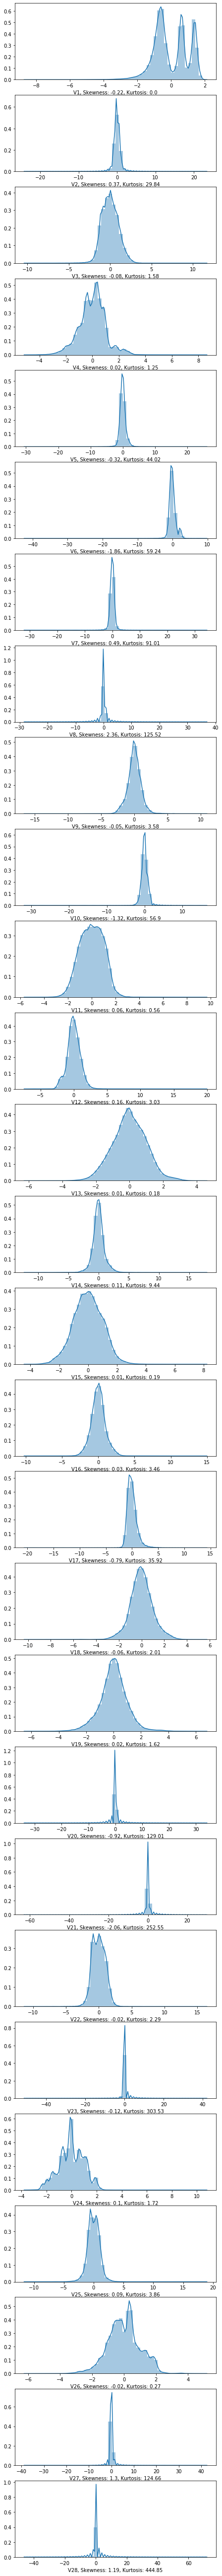

In [324]:
### plot the histogram of a variable from the dataset to see the skewness

plt.figure(figsize=(16,98))

subplotNum = "29,2,"
pltNum = 1
colNumSuf = 1

for i in range(0,28):  # As we have 29 PCA columns lets plot all the columnes and chk the skewness.
    col = "V" + str(colNumSuf)
    colNumSuf = colNumSuf + 1
    
    pltNo = subplotNum + str(pltNum)
    pltNum = pltNum + 1

    plt.subplot(29,2,pltNum)
    sns.distplot(X_train[col],bins=50)
    plt.xlabel(col + ', Skewness: ' + str(np.round(skew(X_train[col]),2)) + ', Kurtosis: ' + str(np.round(kurtosis(X_train[col]),2)))
    
    pltNum = pltNum + 1

## Model Building on Imbalanced data
- Build different models on the imbalanced dataset and see the result

In [221]:
#perform cross validation

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters

### 2.1.1 Logistic regression : Find optimal param using GridSearch

In [34]:
from sklearn import linear_model #import the package
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [37]:
# How to get the correct paramters? CV+Gridsearch CV
# Best C
# L1 or L2 Lasso /Ridge
# Class: Balanced, Weight
start = time.time()
params = {'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,2], 'penalty':['l1','l2']}
logistic = LogisticRegression()

model = GridSearchCV(estimator = logistic, cv = 5, param_grid = params, scoring = "recall")
model.fit(X_train, y_train)

print(model.best_score_)
print(model.best_params_)
end = time.time()

0.6192146700834242
{'C': 0.4, 'penalty': 'l1'}


In [39]:
 (end - start)/60

3.843779734770457

### 2.1.2 Logistic regression : using optimised param

In [ ]:
logreg = LogisticRegression(penalty = 'l1', C=0.4)
logreg.fit(X_train, y_train)

y_train_predict_LR = logreg.predict(X_train)

### Prediction

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_train, y_train_predict_LR)
lr_cm = confusion_matrix(y_train, y_train_predict_LR)
lr_auc = roc_auc_score(y_train, y_train_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives


lr_recall = TP / float(TP+FN)
lr_Specificity = TN / float(TN+FP)
lr_Precision = TP / float(TP+FP)
#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train, y_train_predict_LR))

### Prediction

In [ ]:
y_test_predict_LR = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_test, y_test_predict_LR)
lr_cm = confusion_matrix(y_test, y_test_predict_LR)
lr_auc = roc_auc_score(y_test, y_test_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives


lr_recall = TP / float(TP+FN)
lr_Specificity = TN / float(TN+FP)
lr_Precision = TP / float(TP+FP)
#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_predict_LR))

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### 2.2.1 KNN : Find optimal param using GridSearch

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
k_range = range(1, 11)
score1=[]
score2=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    score1.append(knn.score(X_train,y_train))
    #score2.append(knn.score(X_test,y_test))
    
%matplotlib inline
plt.plot(k_range,score1,label= 'Accuracy on training set')
#plt.plot(k_range,score2,label= 'Accuracy on testing set')
plt.xlabel('Value of K in KNN')
plt.ylabel('Accuracy')
plt.legend()
end = time.time()
elapsed = end - start

In [ ]:
elapsed/60

### 2.2.2 KNN ( Imbalanced data ) : using optimised param

In [86]:
start = time.time()
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
print('Accuracy of KNN n=5 on the training dataset is :{:.3f}'.format(knn.score(X_train,y_train)))
end = time.time()

Accuracy of KNN n=5 on the training dataset is :1.000


In [87]:
(end-start)/60

27.347640550136568

In [88]:
y_train_predict_KNN = knn.predict(X_train)

In [89]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_train, y_train_predict_KNN)
knn_cm = confusion_matrix(y_train, y_train_predict_KNN)
knn_auc = roc_auc_score(y_train, y_train_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

knn_recall = TP / float(TP+FN)
knn_Specificity = TN / float(TN+FP)
knn_Precision = TP / float(TP+FP)
#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train, y_train_predict_KNN))

Accuracy: 99.9644%
ROC AUC: 90.6076%
Sensitivity/Recall 0.8121827411167513
Specificity 0.9999692233287168
Precision 0.9785932721712538
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       0.98      0.81      0.89       394

    accuracy                           1.00    227839
   macro avg       0.99      0.91      0.94    227839
weighted avg       1.00      1.00      1.00    227839



#### KNN: Predict on test

In [92]:
y_test_predict_KNN = knn.predict(X_test)

In [93]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_test, y_test_predict_KNN)
knn_cm = confusion_matrix(y_test, y_test_predict_KNN)
knn_auc = roc_auc_score(y_test, y_test_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

knn_recall = TP / float(TP+FN)
knn_Specificity = TN / float(TN+FP)
knn_Precision = TP / float(TP+FP)
#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_predict_KNN))

Accuracy: 99.9614%
ROC AUC: 90.8128%
Sensitivity/Recall 0.8163265306122449
Specificity 0.999929654250642
Precision 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56960
   macro avg       0.98      0.91      0.94     56960
weighted avg       1.00      1.00      1.00     56960



### 2.3.1 Decision Tree (Imbalanced Data) : Find optimal param using GridSearch

In [81]:
from sklearn.tree import DecisionTreeClassifier
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 50, 5),
    'min_samples_split': range(5, 50, 5),
    'criterion': ["entropy", "gini"]
}


n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds,n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 90.1min finished


We can get accuracy of 0.9994294216530094 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}


### 2.3.2 Decision Tree : using optimised param

In [82]:
# model with optimal hyperparameters
D_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=10)
D_tree.fit(X_train, y_train)

y_train_predict_DT = D_tree.predict(X_train)

### Prediction

In [83]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

T_accuracy = accuracy_score(y_train, y_train_predict_DT)
T_cm = confusion_matrix(y_train, y_train_predict_DT)
T_auc = roc_auc_score(y_train, y_train_predict_DT)

print("ROC AUC: {:.4%}".format(T_auc))
print("Accuracy: {:.4%}".format(T_accuracy))
TP = T_cm[1,1] # true positive 
TN = T_cm[0,0] # true negatives
FP = T_cm[0,1] # false positives
FN = T_cm[1,0] # false negatives


T_recall = TP / float(TP+FN)
T_Specificity = TN / float(TN+FP)
T_Precision = TP / float(TP+FP)
#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train, y_train_predict_DT))

ROC AUC: 90.7310%
Accuracy: 99.9579%
Sensitivity/Recall 0.8147208121827412
Specificity 0.9998988766514981
Precision 0.9331395348837209
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       0.93      0.81      0.87       394

    accuracy                           1.00    227839
   macro avg       0.97      0.91      0.93    227839
weighted avg       1.00      1.00      1.00    227839



In [82]:
# model with optimal hyperparameters
D_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=10)
D_tree.fit(X_train, y_train)

y_train_predict_DT = D_tree.predict(X_train)

### 2.4.1 Random Forest (Imbalanced data) : Grid Search to Find Optimal Hyperparameters

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

We know that there are many hyper parameters for the Random Forest Classifier. We can start by tuning each hyper parameter seprately and find out the best set of values for each parameter so that we can go ahead and build the final Random forest classifier with these parameters.

##### <u> 1.MAX DEPTH

In [58]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 15, 5)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters,cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train,y_train)
end = time.time()

In [59]:
(end - start)/60

1.752525504430135

In [60]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.636826,0.257705,0.124239,0.063503,2,{'max_depth': 2},0.484848,0.564885,0.564885,0.538206,0.037730,3,0.496183,0.577947,0.574144,0.549425,0.037679
1,9.443690,1.178149,0.112325,0.022045,7,{'max_depth': 7},0.757576,0.702290,0.732824,0.730897,0.022611,2,0.797710,0.821293,0.806084,0.808362,0.009762
2,15.055244,1.512154,0.115479,0.002942,12,{'max_depth': 12},0.787879,0.702290,0.755725,0.748632,0.035300,1,0.816794,0.844106,0.840304,0.833735,0.012079


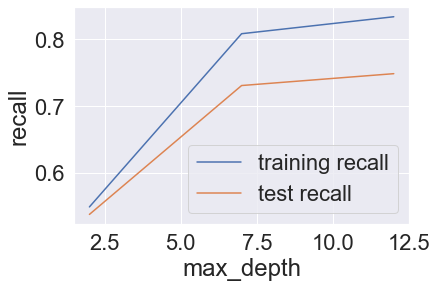

In [61]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Maxmimum depth around 7 would be a good choice for our trees in the randdom forest model.

#### <U> 2.N_ESTIMATORS

In [62]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(500, 1500, 500)}
# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train,y_train)
end = time.time()

In [63]:
# Time Taken to run the model
(end - start)/60

77.90518818298976

In [64]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,424.329137,12.399506,3.757848,0.400864,500,{'n_estimators': 500},0.750000,0.717557,0.740458,0.736005,0.013614,1,0.763359,0.825095,0.806084,0.798179,0.025816
1,867.345330,82.421800,6.692007,1.253801,1000,{'n_estimators': 1000},0.765152,0.702290,0.732824,0.733422,0.025667,2,0.767176,0.825095,0.809886,0.800719,0.024518


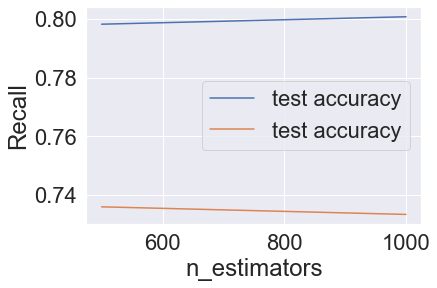

In [65]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="test accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

n_estimators around 500 would be a good choice where the recall values between train and test are much closer.

#### <u> 3.MAX_FEATURES

In [66]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}
# instantiate the model
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train,y_train)
end = time.time()

In [67]:
# Time Taken to run the model in mins
(end - start)/60

6.544865683714549

In [68]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.674941,0.341012,0.096973,0.001545,4,{'max_features': 4},0.742424,0.717557,0.702290,0.720757,0.016540,5,0.732824,0.802281,0.783270,0.772792,0.029308
1,14.348575,1.067905,0.153647,0.041295,8,{'max_features': 8},0.772727,0.725191,0.755725,0.751215,0.019667,4,0.797710,0.840304,0.821293,0.819769,0.017422
2,22.157235,2.931997,0.094986,0.001704,14,{'max_features': 14},0.787879,0.763359,0.763359,0.771532,0.011559,1,0.797710,0.851711,0.832700,0.827374,0.022365
3,30.258433,2.080144,0.100220,0.006666,20,{'max_features': 20},0.780303,0.740458,0.755725,0.758829,0.016414,3,0.809160,0.855513,0.836502,0.833725,0.019025
4,44.264086,3.205780,0.113985,0.029673,24,{'max_features': 24},0.810606,0.763359,0.740458,0.771474,0.029207,2,0.809160,0.855513,0.832700,0.832458,0.018924


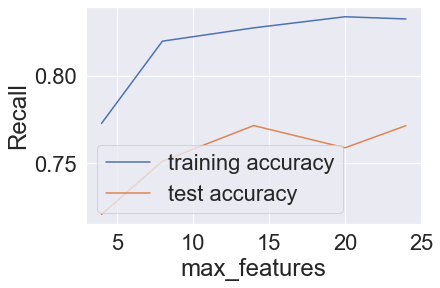

In [69]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

Max features around 13 seems to be a good value for Recall in both train and test and hence we can go ahead with that.

#### <u>4. Min_Samples_Leaf

In [70]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_leaf': range(100,300,50)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train,y_train)
end = time.time()


In [71]:
# Time Taken to run the model in mins
(end-start)/60

3.0839032530784607

In [72]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,14.295155,1.840395,0.122549,0.001600,100,{'min_samples_leaf': 100},0.500000,0.480916,0.534351,0.505089,0.02211,2,0.515267,0.467681,0.532319,0.505089,0.027352
1,12.156020,0.994400,0.116496,0.002948,150,{'min_samples_leaf': 150},0.484848,0.480916,0.564885,0.510217,0.03869,1,0.484733,0.509506,0.570342,0.521527,0.035969
2,12.935596,0.570840,0.120542,0.002635,200,{'min_samples_leaf': 200},0.000000,0.000000,0.000000,0.000000,0.00000,3,0.000000,0.000000,0.000000,0.000000,0.000000
3,11.871950,0.874621,0.117924,0.002357,250,{'min_samples_leaf': 250},0.000000,0.000000,0.000000,0.000000,0.00000,3,0.000000,0.000000,0.000000,0.000000,0.000000


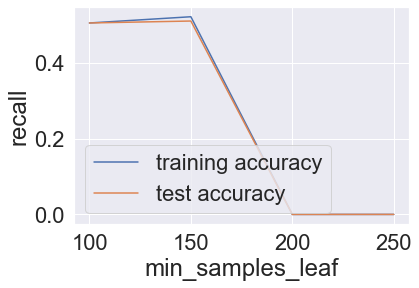

In [73]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("recall")
plt.legend()
plt.show()

#### <u> 5. MIN_SAMPLES_SPLIT

In [74]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_split': range(100, 300, 50)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train,y_train)
end = time.time()
(end-start)/60

4.325999267896017

In [75]:
 # scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,18.262812,0.708548,0.127541,0.002165,100,{'min_samples_split': 100},0.757576,0.694656,0.694656,0.715630,0.029660,1,0.740458,0.779468,0.730038,0.749988,0.021275
1,16.494273,0.579648,0.130535,0.002852,150,{'min_samples_split': 150},0.628788,0.671756,0.633588,0.644710,0.019224,4,0.645038,0.741445,0.680608,0.689030,0.039806
2,19.038724,0.717846,0.246418,0.082154,200,{'min_samples_split': 200},0.689394,0.633588,0.671756,0.664913,0.023291,2,0.648855,0.699620,0.692015,0.680163,0.022355
3,16.702300,2.913328,0.138356,0.010399,250,{'min_samples_split': 250},0.681818,0.618321,0.664122,0.654754,0.026756,3,0.656489,0.676806,0.722433,0.685243,0.027575


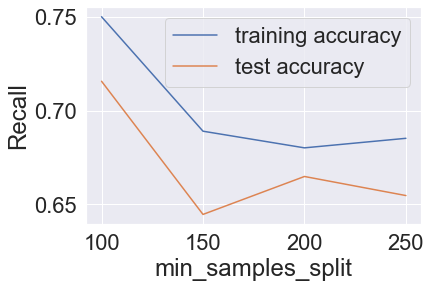

In [76]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.show()

We can combine all the hyper parameter values which we got in the previous steps and build our random forest model with that and observe the metrics which the model is offering on train and test.

### 2.4.2 Random Forest : Tuned Hyperparameter

In [77]:
rf = RandomForestClassifier(n_estimators=500,max_depth=7,max_features=13,min_samples_leaf=75,min_samples_split=150)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=75, min_samples_split=150,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
y_train_pred_rf = rf.predict(X_train)

### Prediction

In [80]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
RF_accuracy = accuracy_score(y_train, y_train_pred_rf)
RF_recall = recall_score(y_train, y_train_pred_rf)
RF_cm = confusion_matrix(y_train, y_train_pred_rf)
RF_auc = roc_auc_score(y_train, y_train_pred_rf)

print("ROC AUC: {:.4%}".format(RF_auc))
print("Accuracy: {:.4%}".format(RF_accuracy))
TP = RF_cm[1,1] # true positive 
TN = RF_cm[0,0] # true negatives
FP = RF_cm[0,1] # false positives
FN = RF_cm[1,0] # false negatives


RF_Specificity = TN / float(TN+FP)
RF_Precision = TP / float(TP+FP)

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train, y_train_pred_rf))

ROC AUC: 85.1409%
Accuracy: 99.9258%
Sensitivity/Recall 0.7030456852791879
Specificity 0.9997713732990393
Precision 0.8419452887537994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       0.84      0.70      0.77       394

    accuracy                           1.00    227839
   macro avg       0.92      0.85      0.88    227839
weighted avg       1.00      1.00      1.00    227839



### 2.5.1 XGBoost: Hyperparameter tuning for XGBoost 

In [95]:
pip install Tensorflow

     |████████████████████████████████| 120.8MB 2.8MB/s eta 0:00:012  |█▍                              | 5.4MB 1.8MB/s eta 0:01:03     |█████▏                          | 19.5MB 6.6MB/s eta 0:00:16     |█████▎                          | 20.0MB 6.6MB/s eta 0:00:16     |██████████▎                     | 38.7MB 3.6MB/s eta 0:00:23     |███████████▊                    | 44.1MB 7.1MB/s eta 0:00:11     |█████████████▋                  | 51.5MB 6.3MB/s eta 0:00:12
     |████████████████████████████████| 61kB 6.1MB/s  eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
     |████████████████████████████████| 450kB 5.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1a/53/9243c600e047b

Successfully built absl-py
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install imblearn

  Using cached https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 163kB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/64/57/23176044d9371e1af286176fd61cf7f74ed46d0b99122624ab93b3f32715/scikit_learn-0.22.2.post1-cp37-cp37m-macosx_10_9_x86_64.whl
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=5ae1c401d46d54cf51c83d0c72b28c585c04575af5aaa60bebed65e51263762e
  Stored in directory: /Users/mamta/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install xgboost

  Using cached https://files.pythonhosted.org/packages/36/a5/703d93321f57048596217789be7c186304a33aff5b1c48c89597a546c65e/xgboost-1.0.2.tar.gz
  Created wheel for xgboost: filename=xgboost-1.0.2-cp37-cp37m-macosx_10_9_x86_64.whl size=3381191 sha256=9999867d61df493635b12c353be158fce9163b7b2c2c5bc57cdcf01dc3d46bd3
  Stored in directory: /Users/mamta/Library/Caches/pip/wheels/2d/88/a6/eae5e2f880d228c2e8c057a2b166a05306f41e1ceaa2a01b45
Successfully built xgboost
Note: you may need to restart the kernel to use updated packages.


#### 1. max_depth

In [36]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}
# instantiate the model
xgb_model = XGBClassifier()
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",return_train_score=True)
xgb_model1.fit(X_train,y_train)
end = time.time()
(end-start)/60

14.326445698738098

In [37]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

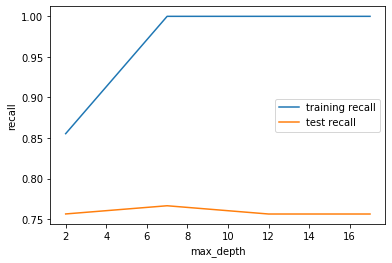

In [38]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_train_score"], 
         label="training recall")
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Max depth around 7 would be a good measure where the train and test recall metrics are close enough.

#### 2. n_estimators

In [52]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(10, 300, 50)}
# instantiate the model (note we are specifying a max_depth)
xgb_model = XGBClassifier(max_depth=7)
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",return_train_score=True)
xgb_model1.fit(X_train,y_train)
end = time.time()
(end-start)/60

24.153509616851807

In [53]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

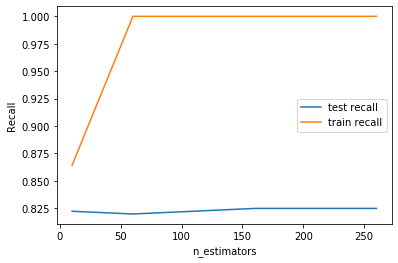

In [54]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_train_score"], 
         label="train recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

50 estimators seems to be a good parameter so that the recall is in similar range on train and test. Further with the increase in the n-estimators we can clearly see some overfitting on the train set.

In [58]:
start = time.time()
# hyperparameter tuning with XGBoost
# creating a KFold object 
folds = 3
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

# specify model
xgb_model = XGBClassifier(max_depth=7, n_estimators=50)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = folds,  
                        verbose = 1,
                        return_train_score=True)  
model_cv.fit(X_train,y_train)
end = time.time()
(end-start)/60

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.3min finished


10.309773270289103

In [59]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,21.525192,0.375424,0.186454,0.011540,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.765152,0.824427,0.770992,0.786857,0.026673,5,0.862595,0.844106,0.855513,0.854072,0.007617
1,33.039172,2.006905,0.198982,0.007902,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.795455,0.854962,0.770992,0.807136,0.035262,3,0.908397,0.901141,0.897338,0.902292,0.004587
2,46.998897,8.905223,0.238587,0.044650,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.803030,0.862595,0.793893,0.819840,0.030462,1,0.938931,0.939163,0.946768,0.941621,0.003641
3,20.617987,2.376970,0.217130,0.004636,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.750000,0.786260,0.740458,0.758906,0.019730,6,0.927481,0.897338,0.912548,0.912456,0.012306
4,27.493636,0.420401,0.232205,0.004250,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.787879,0.824427,0.778626,0.796977,0.019774,4,0.992366,1.000000,1.000000,0.997455,0.003599
5,31.320512,0.587892,0.241730,0.003932,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.818182,0.847328,0.793893,0.819801,0.021845,2,1.000000,1.000000,1.000000,1.000000,0.000000


In [60]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,21.525192,0.375424,0.186454,0.011540,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.765152,0.824427,0.770992,0.786857,0.026673,5,0.862595,0.844106,0.855513,0.854072,0.007617
1,33.039172,2.006905,0.198982,0.007902,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.795455,0.854962,0.770992,0.807136,0.035262,3,0.908397,0.901141,0.897338,0.902292,0.004587
2,46.998897,8.905223,0.238587,0.044650,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.803030,0.862595,0.793893,0.819840,0.030462,1,0.938931,0.939163,0.946768,0.941621,0.003641
3,20.617987,2.376970,0.217130,0.004636,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.750000,0.786260,0.740458,0.758906,0.019730,6,0.927481,0.897338,0.912548,0.912456,0.012306
4,27.493636,0.420401,0.232205,0.004250,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.787879,0.824427,0.778626,0.796977,0.019774,4,0.992366,1.000000,1.000000,0.997455,0.003599


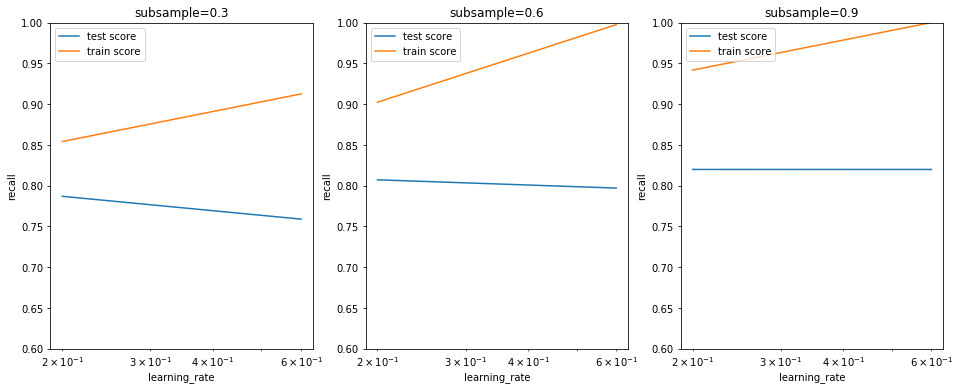

In [61]:
#plotting
plt.figure(figsize=(16,6))
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 
for n, subsample in enumerate(param_grid['subsample']):
    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('recall')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

Learning rate around 0.2 and subsample around 0.3 seems to be a good value.

### 2.5.2 XGBoost Tuned

In [65]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 7, 
          'n_estimators':50,
          'subsample':0.3
         }

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50,
                      'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [66]:
# predict
y_train_pred_xgb = model.predict(X_train)

In [67]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_train, y_train_pred_xgb)
XGB_cm = confusion_matrix(y_train, y_train_pred_xgb)
XGB_auc = roc_auc_score(y_train, y_train_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
XGB_recall = TP / float(TP+FN)
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
XGB_Specificity = TN / float(TN+FP)
print('Specificity',TN / float(TN+FP))

#Precision
XGB_Precision = TP / float(TP+FP)
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train, y_train_pred_xgb))

ROC AUC: 100.0000%
Accuracy: 100.0000%
Sensitivity/Recall 1.0
Specificity 1.0
Precision 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227839
   macro avg       1.00      1.00      1.00    227839
weighted avg       1.00      1.00      1.00    227839



#### XGB:Predict on test

In [68]:
# predict
y_test_pred_xgb = model.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_test, y_test_pred_xgb)
XGB_cm = confusion_matrix(y_test, y_test_pred_xgb)
XGB_auc = roc_auc_score(y_test, y_test_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
XGB_recall = TP / float(TP+FN)
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
XGB_Specificity = TN / float(TN+FP)
print('Specificity',TN / float(TN+FP))

#Precision
XGB_Precision = TP / float(TP+FP)
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_pred_xgb))

ROC AUC: 87.2414%
Accuracy: 99.9491%
Sensitivity/Recall 0.7448979591836735
Specificity 0.999929654250642
Precision 0.948051948051948
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.95      0.74      0.83        98

    accuracy                           1.00     56960
   macro avg       0.97      0.87      0.92     56960
weighted avg       1.00      1.00      1.00     56960



### 3.1. Model Evaluation on unbalanced data

Below is the metric on training data results we can evaluate our model on

Model$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Precision$\;\;\;$ Recall$\;\;\;$ Accuracy$\;\;\;$ ROC_AUC

Logistic(Tuned:lasso)$\;\;\;\;\;\;\;$  0.88$\;\;\;$	0.62$\;\;\;$	0.99$\;\;\;\;\;\;\;\;\;$    0.81

KNN (Tuned,K = 5)$\;\;\;\;\;\;\;$	    0.97$\;\;\;$	0.81$\;\;\;$	0.99$\;\;\;\;\;\;\;\;\;$    0.90   (Best Perfomance)

Decision Tree(Tuned)$\;\;\;\;\;\;\;$      0.93$\;\;\;$	0.81$\;\;\;$	0.99$\;\;\;\;\;\;\;\;\;$    0.90
 
Random Forest(Tuned)$\;\;\;\;\;\;$   0.84$\;\;\;$	0.70$\;\;\;$	0.99$\;\;\;\;\;\;\;\;\;$    0.85

XGBOOST	  (Tuned)$\;\;\;\;\;\;\;\;\;$        0.1$\;\;\;$	0.1$\;\;\;$	    1.00$\;\;\;\;\;\;\;\;\;$  	1.00   (Overfitting)


KNN Test Data  $\;\;\;\;\;\;\;\;\;$	            0.95$\;\;\;$ 	0.81$\;\;\;$	0.99$\;\;\;\;\;\;\;\;\;$    0.90.  (Same as on training data)
### Recommandation:
#### As per above results, KNN(K=5) is giving the best result. Precision and Recall is highest. Whereas XGBOOST os overfitting. Logistic regression has very low precision.


## 4. Model building with balancing Classes

##### Perform class balancing with :
- SMOTE
- ADASYN

## 5. SMOTE Oversampling

### Print the class distribution after applying SMOTE 

In [278]:
from imblearn.over_sampling import SMOTE

In [279]:
#Initialising the SMOTE object
smotesampl = SMOTE(sampling_strategy='minority',random_state=101)

In [280]:
#fit_resample on the train sets to produce the new resampled sets.
X_train_smote,y_train_smote = smotesampl.fit_resample(X_train,y_train)

In [281]:
X_train_smote.shape

(454890, 29)

In [282]:
y_train_smote.shape

(454890,)

In [283]:
X_train_smote = pd.DataFrame(X_train_smote,columns=X_train.columns)

In [284]:
y_train_smote = pd.DataFrame(y_train_smote,columns=['Class'])

In [285]:
X_train_smote.shape

(454890, 29)

In [286]:
y_train_smote.shape

(454890, 1)

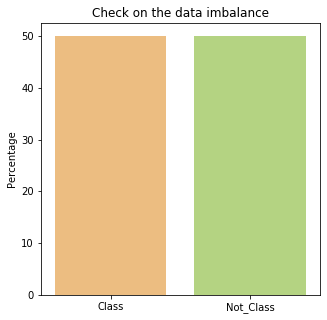

In [287]:
#Data Inbalance check for the Converted column.
yes=y_train_smote[y_train_smote['Class']==1]['Class'].value_counts()
no=y_train_smote[y_train_smote['Class']==0]['Class'].value_counts()

converted=np.array((yes/len(y_train_smote))*100) 
not_converted=np.array((no/len(y_train_smote))*100) 
stat_summ=pd.DataFrame({'Percentage':[converted[0],not_converted[0]]},index=['Class','Not_Class'])
plt.figure(figsize=(5,5))
sns.barplot(x=stat_summ.index,y=stat_summ['Percentage'],palette='RdYlGn')
plt.title('Check on the data imbalance')
plt.show()

We can see that the class imbalance problem has been addressed now with same percentage of total records present now for both the classes.

### 5.1.1 Logistic regression(SMOTE oversampling) : Find optimal param using GridSearch

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [100]:
# How to get the correct paramters? CV+Gridsearch CV
# Best C
# L1 or L2 Lasso /Ridge
# Class: Balanced, Weight
start = time.time()
params = {'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,2], 'penalty':['l1','l2']}
logistic = LogisticRegression()

model = GridSearchCV(estimator = logistic, cv = 5, param_grid = params, scoring = "recall")
model.fit(X_train_smote, y_train_smote)

print(model.best_score_)
print(model.best_params_)
end = time.time()

0.9186484644639364
{'C': 2, 'penalty': 'l2'}


In [101]:
 (end - start)/60

1.2677295366923014

### 5.1.2 Logistic regression((SMOTE oversampling)) : using optimised param

In [104]:
logreg = LogisticRegression(penalty = 'l2', C=2)
logreg.fit(X_train_smote, y_train_smote)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
y_train_smote_predict_LR = logreg.predict(X_train_smote)

### Prediction

In [106]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_train_smote, y_train_smote_predict_LR)
lr_cm = confusion_matrix(y_train_smote, y_train_smote_predict_LR)
lr_auc = roc_auc_score(y_train_smote, y_train_smote_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_smote, y_train_smote_predict_LR))

ROC AUC: 94.6580%
Accuracy: 94.6580%
Sensitivity/Recall 0.918613291125327
Specificity 0.9745476928488206
Precision 0.9730396836854924
              precision    recall  f1-score   support

           0       0.92      0.97      0.95    227445
           1       0.97      0.92      0.95    227445

    accuracy                           0.95    454890
   macro avg       0.95      0.95      0.95    454890
weighted avg       0.95      0.95      0.95    454890



#### LR : predict on test

In [107]:
y_test_smote_predict_LR = logreg.predict(X_test)

In [108]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_test, y_test_smote_predict_LR)
lr_cm = confusion_matrix(y_test, y_test_smote_predict_LR)
lr_auc = roc_auc_score(y_test, y_test_smote_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_smote_predict_LR))

ROC AUC: 94.6451%
Accuracy: 97.4438%
Sensitivity/Recall 0.9183673469387755
Specificity 0.9745348387323696
Precision 0.05851755526657997
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56862
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56960
   macro avg       0.53      0.95      0.55     56960
weighted avg       1.00      0.97      0.99     56960



### Similarly explore other algorithms by building models like:
- KNN
- Decision Tree
- Random Forest
- XGBoost

### 5.2.2 KNN (SMOTE oversampling): using optimised param

In [109]:
start = time.time()
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_smote,y_train_smote)
print('Accuracy of KNN n=5 on the training dataset is :{:.3f}'.format(knn.score(X_train_smote, y_train_smote)))
end = time.time()

Accuracy of KNN n=5 on the training dataset is :0.999


In [110]:
(end-start)/60

38.396840830643974

In [111]:
y_train_smote_predict_KNN = knn.predict(X_train_smote)

In [112]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_train_smote, y_train_smote_predict_KNN)
knn_cm = confusion_matrix(y_train_smote, y_train_smote_predict_KNN)
knn_auc = roc_auc_score(y_train_smote, y_train_smote_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_smote, y_train_smote_predict_KNN))

Accuracy: 99.9435%
ROC AUC: 99.9435%
Sensitivity/Recall 1.0
Specificity 0.9988700564971752
Precision 0.9988713318284425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       1.00      1.00      1.00    227445

    accuracy                           1.00    454890
   macro avg       1.00      1.00      1.00    454890
weighted avg       1.00      1.00      1.00    454890



### KNN: Predict on test

In [113]:
y_test_smote_predict_KNN = knn.predict(X_test)

In [114]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_test, y_test_smote_predict_KNN)
knn_cm = confusion_matrix(y_test, y_test_smote_predict_KNN)
knn_auc = roc_auc_score(y_test, y_test_smote_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_smote_predict_KNN))

Accuracy: 99.8174%
ROC AUC: 91.2500%
Sensitivity/Recall 0.826530612244898
Specificity 0.9984699799514615
Precision 0.48214285714285715
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.48      0.83      0.61        98

    accuracy                           1.00     56960
   macro avg       0.74      0.91      0.80     56960
weighted avg       1.00      1.00      1.00     56960



### 5.3.1 Decision Tree (SMOTE oversampling) : Find optimal param using GridSearch

In [115]:
from sklearn.tree import DecisionTreeClassifier
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 50, 5),
    'min_samples_split': range(5, 50, 5),
    'criterion': ["entropy", "gini"]
}


n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds,n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_smote,y_train_smote)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 79.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 109.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 152.2min finished


We can get accuracy of 0.9873397964343027 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 25}


### 5.3.2 Decision Tree (SMOTE oversampling) : using optimised param

In [124]:
# model with optimal hyperparameters
D_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=25)
D_tree.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [125]:
y_train_smote_predict_DT = D_tree.predict(X_train_smote)

### Prediction

In [126]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

T_accuracy = accuracy_score(y_train_smote, y_train_smote_predict_DT)
T_cm = confusion_matrix(y_train_smote, y_train_smote_predict_DT)
T_auc = roc_auc_score(y_train_smote, y_train_smote_predict_DT)

print("ROC AUC: {:.4%}".format(T_auc))
print("Accuracy: {:.4%}".format(T_accuracy))
TP = T_cm[1,1] # true positive 
TN = T_cm[0,0] # true negatives
FP = T_cm[0,1] # false positives
FN = T_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_smote, y_train_smote_predict_DT))

ROC AUC: 98.7859%
Accuracy: 98.7859%
Sensitivity/Recall 0.9899755984963398
Specificity 0.9857416078612412
Precision 0.9858017232321109
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    227445
           1       0.99      0.99      0.99    227445

    accuracy                           0.99    454890
   macro avg       0.99      0.99      0.99    454890
weighted avg       0.99      0.99      0.99    454890



#### DTree: Predict on test

In [127]:
y_test_smote_predict_DT = D_tree.predict(X_test)

In [128]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

T_accuracy = accuracy_score(y_test, y_test_smote_predict_DT)
T_cm = confusion_matrix(y_test, y_test_smote_predict_DT)
T_auc = roc_auc_score(y_test, y_test_smote_predict_DT)

print("ROC AUC: {:.4%}".format(T_auc))
print("Accuracy: {:.4%}".format(T_accuracy))
TP = T_cm[1,1] # true positive 
TN = T_cm[0,0] # true negatives
FP = T_cm[0,1] # false positives
FN = T_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_smote_predict_DT))

ROC AUC: 90.1208%
Accuracy: 98.5797%
Sensitivity/Recall 0.8163265306122449
Specificity 0.9860891280644367
Precision 0.09184845005740529
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.09      0.82      0.17        98

    accuracy                           0.99     56960
   macro avg       0.55      0.90      0.58     56960
weighted avg       1.00      0.99      0.99     56960



### 5.4.1 Random Forest (SMOTE oversampling) : Grid Search to Find Optimal Hyperparameters

We know that there are many hyper parameters for the Random Forest Classifier. We can start by tuning each hyper parameter seprately and find out the best set of values for each parameter so that we can go ahead and build the final Random forest classifier with these parameters.

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

##### <u> 1.MAX DEPTH

In [117]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 15, 5)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters,cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train_smote,y_train_smote)
end = time.time()

In [118]:
(end - start)/60

22.38249146938324

In [119]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,41.571065,0.396923,0.801072,0.014542,2,{'max_depth': 2},0.860753,0.864460,0.860938,0.862050,0.001705,3,0.861083,0.864262,0.861512,0.862285,0.001408
1,118.268775,0.453400,1.155788,0.002415,7,{'max_depth': 7},0.932454,0.931834,0.934644,0.932977,0.001205,2,0.933509,0.931511,0.935606,0.933542,0.001672
2,177.962584,0.648876,1.590527,0.002733,12,{'max_depth': 12},0.990371,0.990213,0.989619,0.990068,0.000324,1,0.991163,0.990450,0.990563,0.990725,0.000313


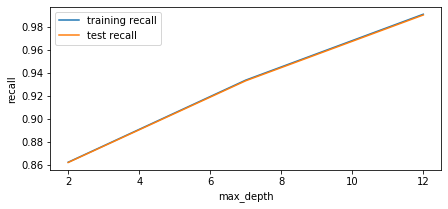

In [120]:
# plotting accuracies with max_depth
plt.figure(figsize=(7,3))
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Maxmimum depth around 7 would be a good choice for our trees in the randdom forest model.

#### <U> 2.N_ESTIMATORS

In [121]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(500, 1500, 500)}
# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train_smote,y_train_smote)
end = time.time()

In [122]:
(end - start)/60

107.74291344881058

In [129]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,591.738855,1.066894,5.612904,0.091975,500,{'n_estimators': 500},0.934353,0.933799,0.933879,0.93401,0.000245,1,0.935620,0.933160,0.935026,0.934602,0.001048
1,1188.275071,9.622961,11.180952,0.183685,1000,{'n_estimators': 1000},0.932837,0.932876,0.933588,0.93310,0.000345,2,0.934373,0.932902,0.934756,0.934010,0.000799


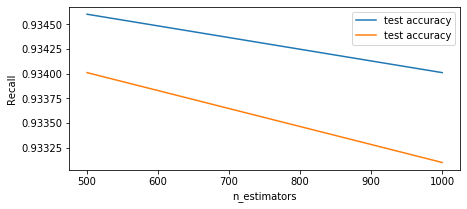

In [130]:
# plotting accuracies with n_estimators
plt.figure(figsize=(7,3))
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="test accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

n_estimators around 500 would be a good choice where the recall values between train and test are much closer.

#### <u> 3.MAX_FEATURES

In [131]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}
# instantiate the model
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_smote,y_train_smote)
end = time.time()

In [132]:
(end - start)/60

104.54980707168579

In [133]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,106.106546,6.998661,1.240233,0.004667,4,{'max_features': 4},0.926123,0.920781,0.925424,0.924109,0.002371,5,0.926743,0.920181,0.926776,0.924566,0.003101
1,220.849068,1.288071,1.483798,0.228107,8,{'max_features': 8},0.944391,0.946172,0.943956,0.944839,0.000959,4,0.945314,0.945980,0.945156,0.945484,0.000357
2,350.680724,9.900558,1.243421,0.047067,14,{'max_features': 14},0.958320,0.958451,0.957963,0.958245,0.000206,3,0.959520,0.957805,0.959151,0.958825,0.000737
3,501.498204,14.241191,1.289620,0.094252,20,{'max_features': 20},0.967051,0.969742,0.965719,0.967504,0.001673,2,0.968707,0.969478,0.966919,0.968368,0.001072
4,559.637028,17.655838,1.176504,0.000500,24,{'max_features': 24},0.970006,0.972525,0.967896,0.970142,0.001893,1,0.971853,0.972941,0.968924,0.971239,0.001696


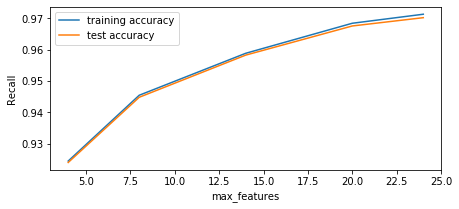

In [134]:
# plotting accuracies with max_features
plt.figure(figsize=(7,3))
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

Max features around 13 seems to be a good value for Recall in both train and test and hence we can go ahead with that.

#### <u>4. Min_Samples_Leaf

In [135]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_leaf': range(100,300,50)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_smote,y_train_smote)
end = time.time()
(end-start)/60

62.18031968275706

In [136]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,191.396549,3.024513,1.781588,0.032413,100,{'min_samples_leaf': 100},0.991677,0.992732,0.992521,0.992310,0.000456,1,0.993049,0.994005,0.993543,0.993533,0.000390
1,202.934621,16.847131,1.685794,0.026403,150,{'min_samples_leaf': 150},0.988657,0.988063,0.987812,0.988177,0.000354,2,0.990140,0.989290,0.988841,0.989424,0.000539
2,183.210275,3.327703,1.656626,0.033777,200,{'min_samples_leaf': 200},0.982444,0.983170,0.983090,0.982901,0.000325,3,0.984680,0.984086,0.984502,0.984423,0.000249
3,534.323007,489.982978,1.650147,0.058386,250,{'min_samples_leaf': 250},0.977445,0.978487,0.977775,0.977902,0.000435,4,0.979483,0.978988,0.979582,0.979351,0.000260


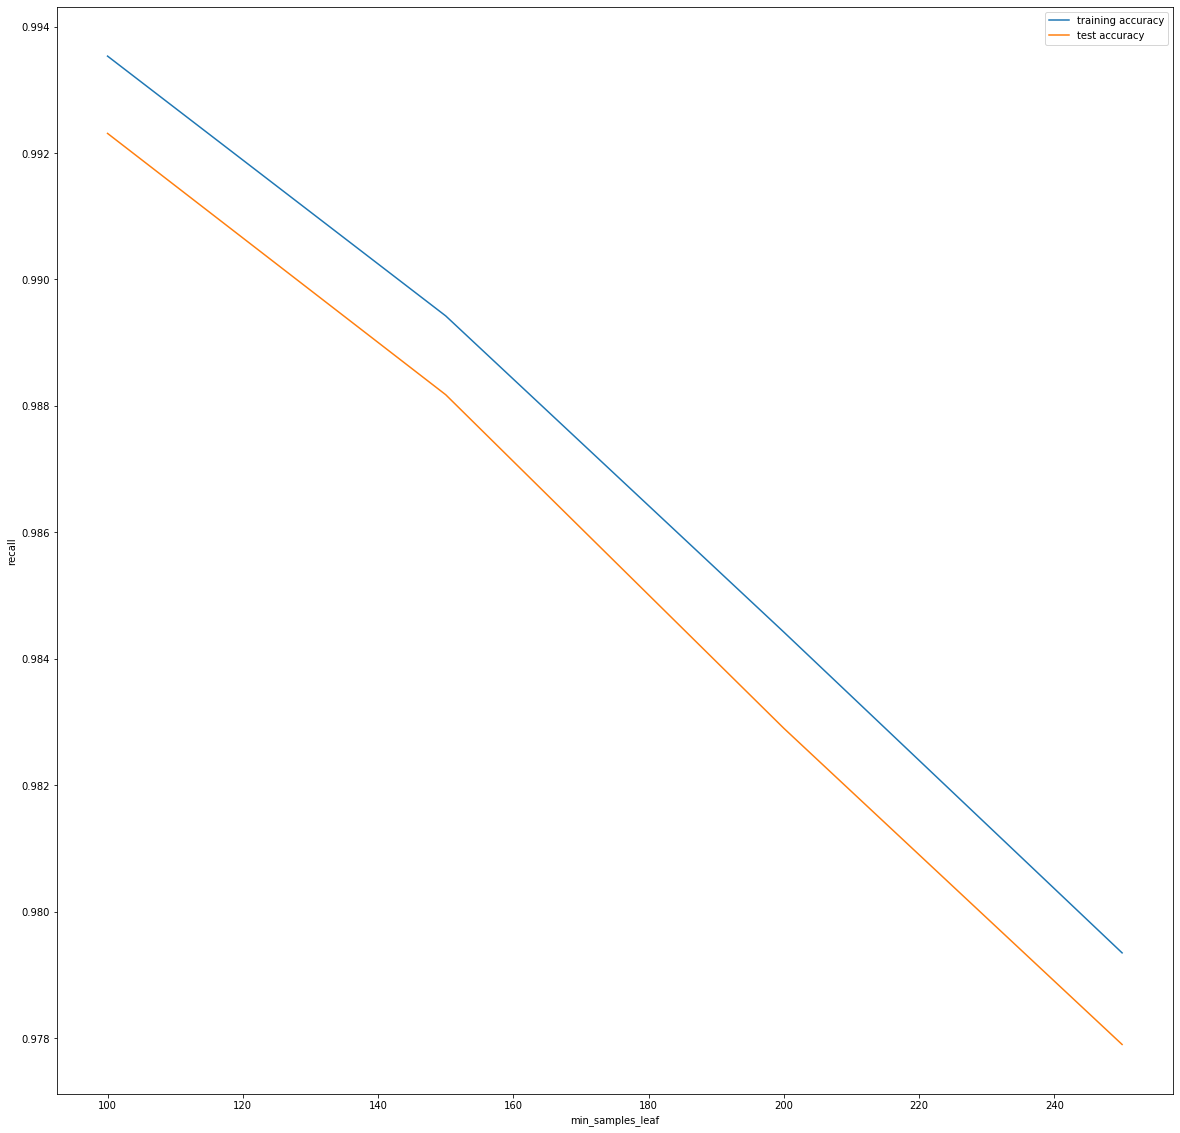

In [137]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("recall")
plt.legend()
plt.show()

#### <u> 5. MIN_SAMPLES_SPLIT

In [138]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_split': range(100, 300, 50)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_smote,y_train_smote)
end = time.time()
(end-start)/60

51.032932086785635

In [139]:
 # scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,221.451137,1.781268,1.870892,0.010663,100,{'min_samples_split': 100},0.998971,0.998839,0.998958,0.998923,0.000059,1,0.999617,0.999413,0.999624,0.999552,0.000098
1,215.293054,2.301827,1.863057,0.023114,150,{'min_samples_split': 150},0.998140,0.997731,0.998219,0.998030,0.000214,2,0.998681,0.998727,0.998833,0.998747,0.000063
2,219.786160,4.724417,1.848781,0.013037,200,{'min_samples_split': 200},0.996505,0.996729,0.996650,0.996628,0.000093,3,0.997468,0.997520,0.997553,0.997514,0.000035
3,218.285712,2.850427,1.843552,0.012055,250,{'min_samples_split': 250},0.995318,0.995621,0.995489,0.995476,0.000124,4,0.996327,0.996828,0.996544,0.996566,0.000205


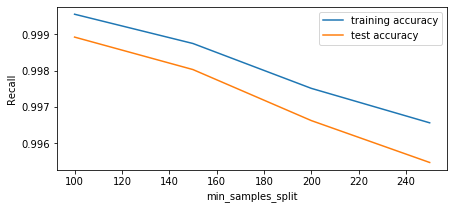

In [140]:
# plotting accuracies with min_samples_split
plt.figure(figsize=(7,3))
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.show()

We can combine all the hyper parameter values which we got in the previous steps and build our random forest model with that and observe the metrics which the model is offering on train and test.

### 6.4.2 Random Forest : Tuned Hyperparameter

In [141]:
rf = RandomForestClassifier(n_estimators=500,max_depth=7,max_features=8,min_samples_leaf=150,min_samples_split=150)
rf.fit(X_train_smote,y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=150, min_samples_split=150,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [142]:
y_train_smote_pred_rf = rf.predict(X_train_smote)

### Prediction

In [143]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
RF_accuracy = accuracy_score(y_train_smote, y_train_smote_pred_rf)
RF_recall = recall_score(y_train_smote, y_train_smote_pred_rf)
RF_cm = confusion_matrix(y_train_smote, y_train_smote_pred_rf)
RF_auc = roc_auc_score(y_train_smote, y_train_smote_pred_rf)

print("ROC AUC: {:.4%}".format(RF_auc))
print("Accuracy: {:.4%}".format(RF_accuracy))
TP = RF_cm[1,1] # true positive 
TN = RF_cm[0,0] # true negatives
FP = RF_cm[0,1] # false positives
FN = RF_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_smote, y_train_smote_pred_rf))

ROC AUC: 96.9412%
Accuracy: 96.9412%
Sensitivity/Recall 0.9428169447558751
Specificity 0.9960078260678406
Precision 0.9957835493412956
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    227445
           1       1.00      0.94      0.97    227445

    accuracy                           0.97    454890
   macro avg       0.97      0.97      0.97    454890
weighted avg       0.97      0.97      0.97    454890



In [144]:
y_test_smote_pred_rf = rf.predict(X_test)

In [145]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
RF_accuracy = accuracy_score(y_test, y_test_smote_pred_rf)
RF_recall = recall_score(y_test, y_test_smote_pred_rf)
RF_cm = confusion_matrix(y_test, y_test_smote_pred_rf)
RF_auc = roc_auc_score(y_test, y_test_smote_pred_rf)

print("ROC AUC: {:.4%}".format(RF_auc))
print("Accuracy: {:.4%}".format(RF_accuracy))
TP = RF_cm[1,1] # true positive 
TN = RF_cm[0,0] # true negatives
FP = RF_cm[0,1] # false positives
FN = RF_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_smote_pred_rf))

ROC AUC: 92.6716%
Accuracy: 99.6050%
Sensitivity/Recall 0.8571428571428571
Specificity 0.9962892617213605
Precision 0.2847457627118644
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.28      0.86      0.43        98

    accuracy                           1.00     56960
   macro avg       0.64      0.93      0.71     56960
weighted avg       1.00      1.00      1.00     56960



### 5.5.1 XGBoost(SMOTE oversampling): Hyperparameter tuning for XGBoost 

#### 1. max_depth

In [81]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}
# instantiate the model
xgb_model = XGBClassifier()
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",return_train_score=True)
xgb_model1.fit(X_train_smote,y_train_smote)
end = time.time()
(end-start)/60

46.41985408465067

In [82]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

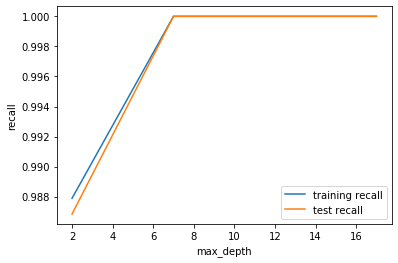

In [83]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_train_score"], 
         label="training recall")
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Max depth around 7 would be a good measure where the train and test recall metrics are close enough.

#### 2. n_estimators

In [84]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(50, 500, 100)}
# instantiate the model (note we are specifying a max_depth)
xgb_model = XGBClassifier(max_depth=7)
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",return_train_score=True)
xgb_model1.fit(X_train_smote,y_train_smote)
end = time.time()
(end-start)/60

108.02399575312933

In [85]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

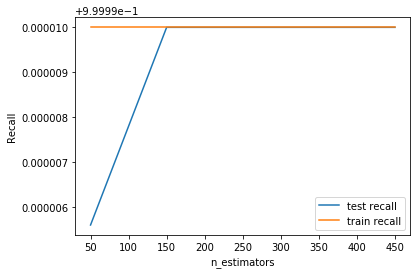

In [86]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_train_score"], 
         label="train recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

100 estimators seems to be a good parameter so that the recall is in similar range on train and test. Further with the increase in the n-estimators we can clearly see some overfitting on the train set.

In [47]:
start = time.time()
# hyperparameter tuning with XGBoost
# creating a KFold object 
folds = 3
# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6,0.9], 
            'subsample': [0.3, 0.6, 0.9]} 


# specify model
xgb_model = XGBClassifier(max_depth=7, n_estimators=150)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = folds,  
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)  
model_cv.fit(X_train_smote,y_train_smote)
end = time.time()
(end-start)/60

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 98.0min finished


103.6952342470487

In [48]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,213.303609,15.008898,1.943033,0.016421,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
1,261.518651,1.035137,2.075964,0.028105,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999987,1.0,1.0,0.999996,0.000006,8,1.0,1.0,1.0,1.0,0.0
2,298.640422,2.922864,2.114219,0.025259,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999987,1.0,1.0,0.999996,0.000006,8,1.0,1.0,1.0,1.0,0.0
3,163.086797,3.006888,1.490904,0.019720,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
4,210.286083,3.713224,1.552520,0.004264,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
5,239.616008,3.859356,1.620985,0.078515,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
6,144.648567,1.063007,1.371581,0.035094,0.9,0.3,"{'learning_rate': 0.9, 'subsample': 0.3}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
7,182.463260,3.146415,1.364660,0.007791,0.9,0.6,"{'learning_rate': 0.9, 'subsample': 0.6}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
8,201.395765,5.099068,1.375284,0.007852,0.9,0.9,"{'learning_rate': 0.9, 'subsample': 0.9}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0


In [49]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,213.303609,15.008898,1.943033,0.016421,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
1,261.518651,1.035137,2.075964,0.028105,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999987,1.0,1.0,0.999996,0.000006,8,1.0,1.0,1.0,1.0,0.0
2,298.640422,2.922864,2.114219,0.025259,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999987,1.0,1.0,0.999996,0.000006,8,1.0,1.0,1.0,1.0,0.0
3,163.086797,3.006888,1.490904,0.019720,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0
4,210.286083,3.713224,1.552520,0.004264,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",1.000000,1.0,1.0,1.000000,0.000000,1,1.0,1.0,1.0,1.0,0.0


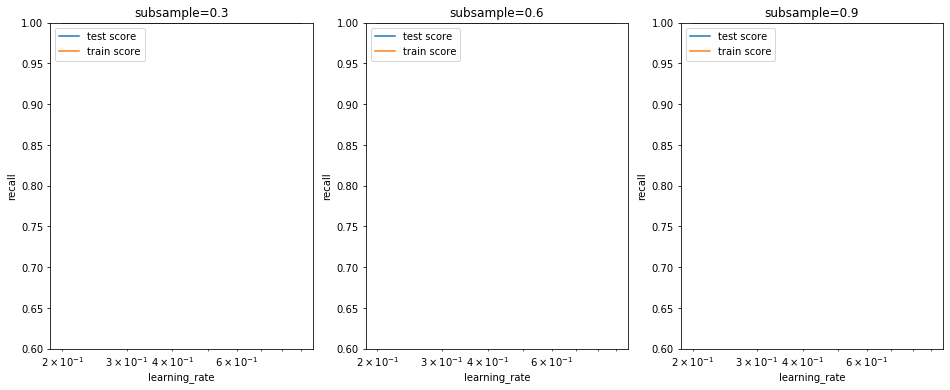

In [51]:
#plotting
plt.figure(figsize=(16,6))
param_grid = {'learning_rate': [0.1,0.2,0.6,0.9], 
            'subsample': [0.1,0.2,0.3]} 
for n, subsample in enumerate(param_grid['subsample']):
    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('recall')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

Learning rate around 0.2 and subsample around 0.3 seems to be a good value.

### 5.5.2 XGBoost (SMOTE overSampling) Tuned

In [288]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 4, 
          'n_estimators':100,
          'subsample':0.3,
         }

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train_smote,y_train_smote)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100,
                      'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [289]:
# predict
y_train_smote_pred_xgb = model.predict(X_train_smote)

In [290]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_train_smote, y_train_smote_pred_xgb)
XGB_cm = confusion_matrix(y_train_smote, y_train_smote_pred_xgb)
XGB_auc = roc_auc_score(y_train_smote, y_train_smote_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_smote, y_train_smote_pred_xgb))

ROC AUC: 99.9991%
Accuracy: 99.9991%
Sensitivity/Recall 1.0
Specificity 0.9999824133306954
Precision 0.9999824136399809
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227445
           1       1.00      1.00      1.00    227445

    accuracy                           1.00    454890
   macro avg       1.00      1.00      1.00    454890
weighted avg       1.00      1.00      1.00    454890



In [291]:
# predict
y_test_smote_pred_xgb = model.predict(X_test)

In [292]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_test, y_test_smote_pred_xgb)
XGB_cm = confusion_matrix(y_test, y_test_smote_pred_xgb)
XGB_auc = roc_auc_score(y_test, y_test_smote_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_smote_pred_xgb))

ROC AUC: 92.8272%
Accuracy: 99.9157%
Sensitivity/Recall 0.8571428571428571
Specificity 0.9994020611304562
Precision 0.711864406779661
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.71      0.86      0.78        98

    accuracy                           1.00     56960
   macro avg       0.86      0.93      0.89     56960
weighted avg       1.00      1.00      1.00     56960



In [293]:
# feature importance
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'V1': 0.01662315,
 'V2': 0.018842509,
 'V3': 0.011636265,
 'V4': 0.061132226,
 'V5': 0.010345753,
 'V6': 0.0101080835,
 'V7': 0.015358669,
 'V8': 0.040048447,
 'V9': 0.016766928,
 'V10': 0.014663321,
 'V11': 0.015778469,
 'V12': 0.020311307,
 'V13': 0.017741092,
 'V14': 0.57507896,
 'V15': 0.012361592,
 'V16': 0.0045755976,
 'V17': 0.019669624,
 'V18': 0.014344557,
 'V19': 0.008497328,
 'V20': 0.007848477,
 'V21': 0.013049811,
 'V22': 0.009631922,
 'V23': 0.013487243,
 'V24': 0.0037846104,
 'V25': 0.00940954,
 'V26': 0.010527258,
 'V27': 0.005328756,
 'V28': 0.010428889,
 'Amount': 0.0126196}

##### Build models on other algorithms to see the better performing on SMOTE

## 6. ADASYN Oversampling

### Print the class distribution after applying ADASYN

In [245]:
from imblearn.over_sampling import ADASYN

In [246]:
#Initialising the ADASYN object
ada = ADASYN(sampling_strategy='minority',random_state=101)

In [247]:
#fit_resample on the train sets to produce the new resampled sets.
X_train_ada,y_train_ada = ada.fit_resample(X_train,y_train)

In [248]:
X_train_ada.shape

(454907, 29)

In [249]:
y_train_ada.shape

(454907,)

We can see that currently we are having 398092 records with us after performing the ADASYN. Since the output of ADASYN is an nd array we can convert it back to dataframes. Further we can check what is the distribution of classes right now.

In [250]:
X_train_ada = pd.DataFrame(X_train_ada,columns=X_train.columns)

In [251]:
X_train_ada.shape

(454907, 29)

In [252]:
y_train_ada = pd.DataFrame(y_train_ada,columns=['Class'])

In [253]:
y_train_ada.shape

(454907, 1)

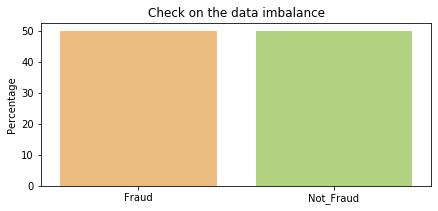

In [254]:
#Data Inbalance check for the Converted column.
yes=y_train_ada[y_train_ada['Class']==1]['Class'].value_counts()
no=y_train_ada[y_train_ada['Class']==0]['Class'].value_counts()

plt.figure(figsize=(7,3))
converted=np.array((yes/len(y_train_ada))*100) 
not_converted=np.array((no/len(y_train_ada))*100) 
stat_summ=pd.DataFrame({'Percentage':[converted[0],not_converted[0]]},index=['Fraud','Not_Fraud'])
sns.barplot(x=stat_summ.index,y=stat_summ['Percentage'],palette='RdYlGn')
plt.title('Check on the data imbalance')
plt.show()

We can see that the class imbalance problem has been addressed now with same percentage of total records present now for both the classes.

In [43]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


### 6.1.1 Logistic regression(ADASYN oversampling): Find optimal param using GridSearch

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [90]:
# How to get the correct paramters? CV+Gridsearch CV
# Best C
# L1 or L2 Lasso /Ridge
# Class: Balanced, Weight
start = time.time()
params = {'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,2], 'penalty':['l1','l2']}
logistic = LogisticRegression()

model = GridSearchCV(estimator = logistic, cv = 5, param_grid = params, scoring = "recall")
model.fit(X_train_ada, y_train_ada)

print(model.best_score_)
print(model.best_params_)
end = time.time()

0.8515049236199639
{'C': 2, 'penalty': 'l2'}


In [91]:
 (end - start)/60

1.1467564860979715

### 6.1.2 Logistic regression (ADASYN oversampling): using optimised param

In [47]:
logreg = LogisticRegression(penalty = 'l2', C=2.0)
logreg.fit(X_train_ada, y_train_ada)

y_train_ada_predict_LR = logreg.predict(X_train_ada)

### Prediction

In [48]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_train_ada, y_train_ada_predict_LR)
lr_cm = confusion_matrix(y_train_ada, y_train_ada_predict_LR)
lr_auc = roc_auc_score(y_train_ada, y_train_ada_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_ada, y_train_ada_predict_LR))

ROC AUC: 88.6210%
Accuracy: 88.6208%
Sensitivity/Recall 0.8661564431471501
Specificity 0.9062630526061246
Precision 0.9023608344210117
              precision    recall  f1-score   support

           0       0.87      0.91      0.89    227445
           1       0.90      0.87      0.88    227482

    accuracy                           0.89    454927
   macro avg       0.89      0.89      0.89    454927
weighted avg       0.89      0.89      0.89    454927



### Logistic Regresssion : predict on test

In [49]:
y_test_ada_predict_LR = logreg.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_test, y_test_ada_predict_LR)
lr_cm = confusion_matrix(y_test, y_test_ada_predict_LR)
lr_auc = roc_auc_score(y_test, y_test_ada_predict_LR)

print("ROC AUC: {:.4%}".format(lr_auc))
print("Accuracy: {:.4%}".format(lr_accuracy))

TP = lr_cm[1,1] # true positive 
TN = lr_cm[0,0] # true negatives
FP = lr_cm[0,1] # false positives
FN = lr_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_ada_predict_LR))

ROC AUC: 93.7896%
Accuracy: 90.6513%
Sensitivity/Recall 0.9693877551020408
Specificity 0.9064049804790546
Precision 0.017537382314934465
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56862
           1       0.02      0.97      0.03        98

    accuracy                           0.91     56960
   macro avg       0.51      0.94      0.49     56960
weighted avg       1.00      0.91      0.95     56960



 Logistic regression performing same on train and test and giving a good accuaracy of 87%

### Similarly explore other algorithms by building models like:
- KNN
- Decision Tree
- Random Forest
- XGBoost

### Shuffling and sampling the train set to produce a new train set from the ADASYN datapoints.

In [255]:
X_train_ada.shape

(454907, 29)

In [256]:
y_train_ada.shape

(454907, 1)

In [257]:
X_train_ada_new = X_train_ada.copy()

In [258]:
X_train_ada_new['Class'] = y_train_ada['Class']

In [259]:
X_train_ada_fraud = X_train_ada_new.loc[X_train_ada_new['Class']==1]

In [260]:
X_train_ada_non_fraud = X_train_ada_new.loc[X_train_ada_new['Class']==0]

In [261]:
X_train_ada_fraud.shape

(227462, 30)

In [262]:
X_train_ada_non_fraud.shape

(227445, 30)

In [263]:
X_train_ada_fraud = X_train_ada_fraud.sample(frac=1)

In [264]:
X_train_ada_non_fraud = X_train_ada_non_fraud.sample(frac=1)

In [265]:
X_train_ada_fraud = X_train_ada_fraud[:50000]
X_train_ada_non_fraud = X_train_ada_non_fraud[:50000]

In [266]:
frames = [X_train_ada_fraud,X_train_ada_non_fraud]
X_train_ada_final = pd.concat(frames)

In [267]:
X_train_ada_final = X_train_ada_final.sample(frac=1)

In [268]:
X_train_ada_final

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
27290,1.335535,-0.516440,-0.296401,0.250202,-0.635869,0.011406,-0.743158,0.010579,1.341232,0.026739,...,0.025231,0.068399,0.336952,-1.069906,-1.040354,1.086113,-0.082402,-0.110201,0.275489,0
67608,-0.525349,0.220137,1.515551,0.413002,-0.106459,0.470721,0.262189,0.309614,0.239311,-0.635923,...,0.142608,0.636165,-0.119297,0.288342,-0.136629,-1.068349,0.235930,0.165006,0.006993,0
100711,1.697089,-0.476902,-1.158851,-0.788922,-0.025742,-0.610918,-0.227801,-0.475041,-0.531210,0.804553,...,0.539072,1.636701,-0.266175,-1.430878,0.711336,0.358469,-0.107763,-0.219101,-0.572886,0
210073,1.575362,-0.062309,-1.541975,-0.047236,0.662165,-0.940434,0.619119,-0.537314,0.385189,0.071144,...,0.133799,0.476344,-0.281464,-1.565353,1.048688,0.709385,-0.249945,-0.270332,-0.681888,0
329142,-1.216775,1.058119,-0.480256,1.130174,-0.744381,-0.284807,-0.689589,0.087773,-0.572428,-2.072535,...,0.354040,-0.008555,-0.022044,-0.213342,0.119713,-1.088823,-0.532977,-0.469140,0.551050,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33546,-2.655715,0.407183,0.208157,2.484330,2.410697,0.838019,-8.238921,-5.641483,-0.100006,0.444087,...,-9.144441,1.712837,-7.300375,-0.575004,-2.997732,0.415952,0.954560,0.247738,-1.079968,0
433536,-1.647450,2.268181,-2.788558,2.446794,-1.569354,-1.618078,-4.306345,2.757905,-2.959235,-6.730380,...,1.272637,-0.063844,-0.936952,-0.974798,0.145110,-0.223588,2.968834,0.701505,-0.683210,1
382712,0.659694,-0.498685,-0.361923,-0.341325,-0.439281,-0.199002,-0.397819,-0.096992,-0.673452,0.244904,...,-0.013109,-0.415035,-0.309756,-0.775136,0.928107,-0.564597,-0.023112,0.125662,1.064907,1
381317,0.667216,-0.507785,-0.451365,-0.255649,-0.412427,-0.266931,-0.325660,-0.125338,-0.524339,0.090964,...,0.006856,-0.393845,-0.313879,-0.750990,0.822487,-0.639255,-0.022244,0.136032,1.142852,1


In [269]:
X_train_ada_sampled = X_train_ada_final.drop(['Class'],axis=1)
y_train_ada_sampled = X_train_ada_final['Class']

In [67]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE

#perform hyperparameter tuning

#print the evaluation result by choosing a evaluation metric

#print the optimum value of hyperparameters


### 6.2.1 KNN (ADASYN oversampling) : using optimised param

In [68]:
start = time.time()
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_ada_sampled,y_train_ada_sampled)
print('Accuracy of KNN n=5 on the training dataset is :{:.3f}'.format(knn.score(X_train_ada_sampled,y_train_ada_sampled)))
end = time.time()

Accuracy of KNN n=5 on the training dataset is :0.997


In [69]:
(end-start)/60

4.2201558470726015

In [70]:
y_train_ada_predict_KNN = knn.predict(X_train_ada_sampled)

In [71]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_train_ada_sampled, y_train_ada_predict_KNN)
knn_cm = confusion_matrix(y_train_ada_sampled, y_train_ada_predict_KNN)
knn_auc = roc_auc_score(y_train_ada_sampled, y_train_ada_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_ada_sampled, y_train_ada_predict_KNN))

Accuracy: 99.7450%
ROC AUC: 99.7450%
Sensitivity/Recall 1.0
Specificity 0.9949
Precision 0.9949258780220873
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50000
           1       0.99      1.00      1.00     50000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



### KNN : predict on test

In [72]:
y_test_ada_predict_KNN = knn.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

knn_accuracy = accuracy_score(y_test, y_test_ada_predict_KNN)
knn_cm = confusion_matrix(y_test, y_test_ada_predict_KNN)
knn_auc = roc_auc_score(y_test, y_test_ada_predict_KNN)

print("Accuracy: {:.4%}".format(knn_accuracy))
print("ROC AUC: {:.4%}".format(knn_auc))
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_ada_predict_KNN))

Accuracy: 99.2802%
ROC AUC: 91.4903%
Sensitivity/Recall 0.8367346938775511
Specificity 0.9930709436882277
Precision 0.1722689075630252
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56862
           1       0.17      0.84      0.29        98

    accuracy                           0.99     56960
   macro avg       0.59      0.91      0.64     56960
weighted avg       1.00      0.99      1.00     56960



### 6.3.1 Decision Tree (ADASYN oversampling) : Find optimal param using GridSearch

In [113]:
from sklearn.tree import DecisionTreeClassifier
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(5, 50, 5),
    'min_samples_split': range(5, 50, 5),
    'criterion': ["entropy", "gini"]
}


n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds,n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_ada_sampled,y_train_ada_sampled)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 30.1min finished


We can get accuracy of 0.9796199999999999 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}


### 6.3.2 Decision Tree(ADASYN oversampling) : using optimised param

In [88]:
# model with optimal hyperparameters
start = time.time()
D_tree = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=5,
                                  min_samples_split=5)
D_tree.fit(X_train_ada_sampled, y_train_ada_sampled)

y_train_ada_predict_DT = D_tree.predict(X_train_ada_sampled)


end = time.time()
# time take by modelto run
(end-start)/60

### Prediction

In [89]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

T_accuracy = accuracy_score(y_train_ada_sampled, y_train_ada_predict_DT)
T_cm = confusion_matrix(y_train_ada_sampled, y_train_ada_predict_DT)
T_auc = roc_auc_score(y_train_ada_sampled, y_train_ada_predict_DT)

print("ROC AUC: {:.4%}".format(T_auc))
print("Accuracy: {:.4%}".format(T_accuracy))
TP = T_cm[1,1] # true positive 
TN = T_cm[0,0] # true negatives
FP = T_cm[0,1] # false positives
FN = T_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_ada_sampled, y_train_ada_predict_DT))

ROC AUC: 98.2330%
Accuracy: 98.2330%
Sensitivity/Recall 0.994
Specificity 0.97066
Precision 0.9713291770086189
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     50000
           1       0.97      0.99      0.98     50000

    accuracy                           0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000



### Decision Tree: predict on test

In [90]:
y_test_ada_pred_DT = rf.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
DT_accuracy = accuracy_score(y_test, y_test_ada_pred_DT)
DT_recall = recall_score(y_test, y_test_ada_pred_DT)
DT_cm = confusion_matrix(y_test, y_test_ada_pred_DT)
DT_auc = roc_auc_score(y_test, y_test_ada_pred_DT)

print("ROC AUC: {:.4%}".format(DT_auc))
print("Accuracy: {:.4%}".format(DT_accuracy))
TP = DT_cm[1,1] # true positive 
TN = DT_cm[0,0] # true negatives
FP = DT_cm[0,1] # false positives
FN = DT_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_ada_pred_DT))

ROC AUC: 93.3240%
Accuracy: 96.8399%
Sensitivity/Recall 0.8979591836734694
Specificity 0.9685202771622524
Precision 0.046858359957401494
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56862
           1       0.05      0.90      0.09        98

    accuracy                           0.97     56960
   macro avg       0.52      0.93      0.54     56960
weighted avg       1.00      0.97      0.98     56960



### 6.4.1 Random Forest (ADASYN oversampling) : Grid Search to Find Optimal Hyperparameters

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

We know that there are many hyper parameters for the Random Forest Classifier. We can start by tuning each hyper parameter seprately and find out the best set of values for each parameter so that we can go ahead and build the final Random forest classifier with these parameters.

##### <u> 1.MAX DEPTH

In [145]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 15, 5)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters,cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()

In [146]:
(end - start)/60

3.802927800019582

In [147]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.351772,0.810241,0.233054,0.060611,2,{'max_depth': 2},0.775544,0.729029,0.767925,0.757499,0.020370,3,0.774458,0.733935,0.770948,0.75978,0.018331
1,20.790942,0.653737,0.291072,0.001155,7,{'max_depth': 7},0.976780,0.970539,0.970721,0.972680,0.002900,2,0.977560,0.971081,0.972910,0.97385,0.002727
2,28.886175,0.096874,0.379061,0.001231,12,{'max_depth': 12},1.000000,1.000000,0.999940,0.999980,0.000028,1,1.000000,1.000000,1.000000,1.00000,0.000000


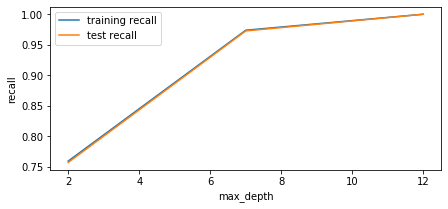

In [148]:
# plotting accuracies with max_depth
plt.figure(figsize=(7,3))
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Maxmimum depth around 7 would be a good choice for our trees in the randdom forest model.

#### <U> 2.N_ESTIMATORS

In [63]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(200, 1500, 500)}
# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds,scoring="recall",return_train_score=True)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()

In [64]:
(end - start)/60

26.655536631743114

In [65]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,47.198137,3.474105,0.579186,0.013525,200,{'n_estimators': 200},0.960221,0.965079,0.965741,0.96368,0.002461,3,0.96637,0.964751,0.96463,0.96525,0.000793
1,142.898411,0.492205,1.965915,0.036180,700,{'n_estimators': 700},0.959621,0.965619,0.966461,0.96390,0.003045,1,0.96649,0.964451,0.96559,0.96551,0.000834
2,248.436361,5.484739,3.312726,0.015548,1200,{'n_estimators': 1200},0.960701,0.964419,0.966521,0.96388,0.002406,2,0.96721,0.964091,0.96520,0.96550,0.001291


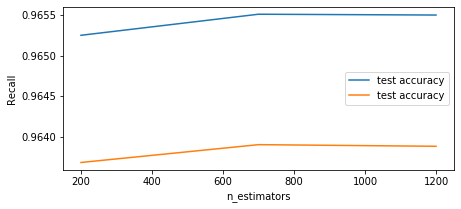

In [66]:
# plotting accuracies with n_estimators
plt.figure(figsize=(7,3))
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="test accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

n_estimators around 700 would be a good choice where the recall values between train and test are much closer.

#### <u> 3.MAX_FEATURES

In [141]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}
# instantiate the model
rf = RandomForestClassifier(max_depth=7)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()

In [142]:
(end - start)/60

16.84810094833374

In [143]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,17.465719,1.348760,0.293199,0.000887,4,{'max_features': 4},0.970181,0.964059,0.967721,0.96732,0.002515,5,0.97099,0.965501,0.96946,0.96865,0.002313
1,31.496378,0.034259,0.285866,0.000652,8,{'max_features': 8},0.984040,0.985239,0.984280,0.98452,0.000518,4,0.98299,0.986560,0.98662,0.98539,0.001697
2,54.019250,0.205522,0.279564,0.000780,14,{'max_features': 14},0.988480,0.987880,0.989080,0.98848,0.000490,3,0.98764,0.988510,0.99124,0.98913,0.001534
3,82.094404,4.116861,0.305729,0.029424,20,{'max_features': 20},0.989560,0.989380,0.988900,0.98928,0.000278,1,0.98869,0.990940,0.99151,0.99038,0.001218
4,106.733747,4.549184,0.280884,0.002360,24,{'max_features': 24},0.991000,0.988120,0.988420,0.98918,0.001293,2,0.99055,0.989230,0.99088,0.99022,0.000713


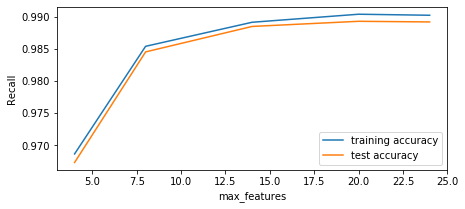

In [144]:
# plotting accuracies with max_features
plt.figure(figsize=(7,3))
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

Max features around 5 seems to be a good value for Recall in both train and test and hence we can go ahead with that.

#### <u>4. Min_Samples_Leaf

In [129]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_leaf': range(100,300,50)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
(end-start)/60

6.113895833492279

In [130]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,27.528508,0.164859,0.388264,0.001314,100,{'min_samples_leaf': 100},0.99766,0.994540,0.99604,0.99608,0.001274,1,0.99802,0.99592,0.99766,0.99720,0.000917
1,26.126193,0.160261,0.376038,0.001365,150,{'min_samples_leaf': 150},0.99232,0.990640,0.98908,0.99068,0.001323,2,0.99208,0.99307,0.99118,0.99211,0.000772
2,24.864757,0.220986,0.366030,0.000852,200,{'min_samples_leaf': 200},0.98794,0.988660,0.98746,0.98802,0.000493,3,0.98845,0.98977,0.98986,0.98936,0.000645
3,24.050577,0.183935,0.356581,0.000929,250,{'min_samples_leaf': 250},0.98338,0.983739,0.98098,0.98270,0.001225,4,0.98485,0.98380,0.98464,0.98443,0.000453


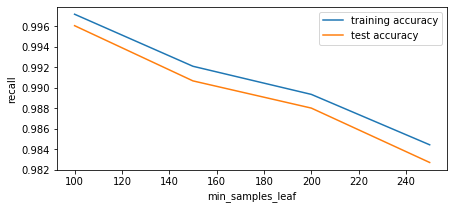

In [137]:
# plotting accuracies with min_samples_leaf
plt.figure(figsize=(7,3))
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("recall")
plt.legend()
plt.show()

#### <u> 5. MIN_SAMPLES_SPLIT

In [67]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'min_samples_split': range(100, 600, 100)}
# instantiate the model
rf = RandomForestClassifier()
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, scoring="recall",return_train_score=True)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
(end-start)/60

11.83867313861847

In [68]:
 # scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,42.003731,0.986301,0.464043,0.009061,100,{'min_samples_split': 100},0.99952,0.99916,0.99874,0.99914,0.000319,1,0.99997,0.99973,0.99952,0.99974,0.000184
1,42.210814,2.633876,0.475965,0.045204,200,{'min_samples_split': 200},0.99712,0.99772,0.99748,0.99744,0.000247,2,0.99826,0.99841,0.99871,0.99846,0.000187
2,39.559056,2.880779,0.460039,0.032794,300,{'min_samples_split': 300},0.99328,0.99478,0.99328,0.99378,0.000707,3,0.99466,0.99559,0.99508,0.99511,0.000380
3,42.133699,0.909530,0.508395,0.058781,400,{'min_samples_split': 400},0.98980,0.99262,0.99178,0.99140,0.001182,4,0.99238,0.99349,0.99349,0.99312,0.000523
4,39.977341,0.537738,0.458090,0.024079,500,{'min_samples_split': 500},0.98806,0.99028,0.98698,0.98844,0.001373,5,0.98983,0.99085,0.98956,0.99008,0.000556


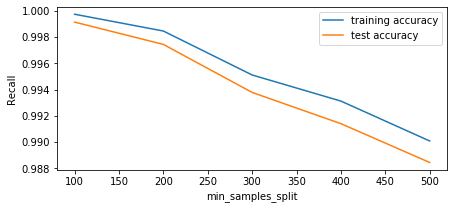

In [69]:
# plotting accuracies with min_samples_split
plt.figure(figsize=(7,3))
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.show()

We can combine all the hyper parameter values which we got in the previous steps and build our random forest model with that and observe the metrics which the model is offering on train and test.

### 6.4.2 Random Forest (ADASYN oversampling): Tuned Hyperparameter

In [149]:
start = time.time()
rf = RandomForestClassifier(n_estimators=700,max_depth=7,max_features=5,min_samples_leaf=150,min_samples_split=200)
rf.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
# time taken by model execution
(end-start)/60

4.477100869019826

In [150]:
y_train_ada_pred_rf = rf.predict(X_train_ada_sampled)

### Prediction

In [151]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
RF_accuracy = accuracy_score(y_train_ada_sampled, y_train_ada_pred_rf)
RF_recall = recall_score(y_train_ada_sampled, y_train_ada_pred_rf)
RF_cm = confusion_matrix(y_train_ada_sampled, y_train_ada_pred_rf)
RF_auc = roc_auc_score(y_train_ada_sampled, y_train_ada_pred_rf)

print("ROC AUC: {:.4%}".format(RF_auc))
print("Accuracy: {:.4%}".format(RF_accuracy))
TP = RF_cm[1,1] # true positive 
TN = RF_cm[0,0] # true negatives
FP = RF_cm[0,1] # false positives
FN = RF_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_ada_sampled, y_train_ada_pred_rf))

ROC AUC: 96.5830%
Accuracy: 96.5830%
Sensitivity/Recall 0.96114
Specificity 0.97052
Precision 0.9702408592598575
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     50000
           1       0.97      0.96      0.97     50000

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



###  Random Forest: Predict on Test

In [152]:
y_test_ada_pred_rf = rf.predict(X_test)

In [153]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot
RF_accuracy = accuracy_score(y_test, y_test_ada_pred_rf)
RF_recall = recall_score(y_test, y_test_ada_pred_rf)
RF_cm = confusion_matrix(y_test, y_test_ada_pred_rf)
RF_auc = roc_auc_score(y_test, y_test_ada_pred_rf)

print("ROC AUC: {:.4%}".format(RF_auc))
print("Accuracy: {:.4%}".format(RF_accuracy))
TP = RF_cm[1,1] # true positive 
TN = RF_cm[0,0] # true negatives
FP = RF_cm[0,1] # false positives
FN = RF_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_ada_pred_rf))

ROC AUC: 92.3774%
Accuracy: 96.9838%
Sensitivity/Recall 0.8775510204081632
Specificity 0.9699975378987725
Precision 0.04799107142857143
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56862
           1       0.05      0.88      0.09        98

    accuracy                           0.97     56960
   macro avg       0.52      0.92      0.54     56960
weighted avg       1.00      0.97      0.98     56960



Random forest was giving good perfomance on Training set but taking a hit on precision on test data

### 6.5.1 XGBoost(ADASYN oversampling): Hyperparameter tuning for XGBoost 

In [270]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#### 1. max_depth

In [117]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'max_depth': range(2, 10, 2)}
# instantiate the model
xgb_model = XGBClassifier()
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",n_jobs=-1,return_train_score=True)
xgb_model1.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
(end-start)/60

5.255327920118968

In [118]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

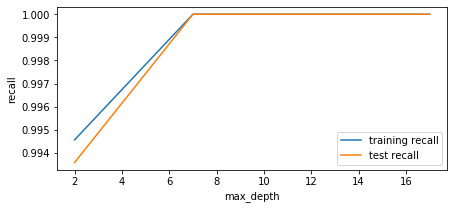

In [119]:
# plotting accuracies with max_depth
plt.figure(figsize=(7,3))
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_train_score"], 
         label="training recall")
plt.plot(cv_results["param_max_depth"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()
plt.show()

Max depth around 7 would be a good measure where the train and test recall metrics are close enough.

#### 2. n_estimators

In [64]:
start = time.time()
# specify number of folds for k-fold CV
n_folds = 3
# parameters to build the model on
parameters = {'n_estimators': range(10, 200, 30)}
# instantiate the model (note we are specifying a max_depth)
xgb_model = XGBClassifier(max_depth=2)
# fit tree on training data
xgb_model1 = GridSearchCV(xgb_model, parameters, cv=n_folds, scoring="recall",n_jobs=-1,return_train_score=True)
xgb_model1.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
(end-start)/60

7.54395991563797

In [65]:
cv_results = pd.DataFrame(xgb_model1.cv_results_)

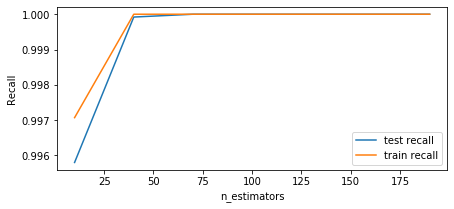

In [66]:
# plotting accuracies with n_estimators
plt.figure(figsize=(7,3))
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_test_score"], 
         label="test recall")
plt.plot(cv_results["param_n_estimators"], 
         cv_results["mean_train_score"], 
         label="train recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

25 estimators seems to be a good parameter so that the recall is in similar range on train and test. Further with the increase in the n-estimators we can clearly see some overfitting on the train set.

In [125]:
start = time.time()
# hyperparameter tuning with XGBoost
# creating a KFold object 
folds = 3
# specify range of hyperparameters
param_grid = {'learning_rate': [0.01,0.1,0.2, 0.6], 
             'subsample': [0.1,0.2, 0.3, 0.6]}          

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=25)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = folds,  
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)  
model_cv.fit(X_train_ada_sampled,y_train_ada_sampled)
end = time.time()
(end-start)/60

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.1min finished


1.146385383605957

In [126]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.791598,0.023068,0.119671,0.002757,0.01,0.1,"{'learning_rate': 0.01, 'subsample': 0.1}",0.824264,0.818984,0.809072,0.817440,0.006297,13,0.824438,0.822218,0.810434,0.81903,0.006146
1,3.909857,0.401640,0.110191,0.010088,0.01,0.2,"{'learning_rate': 0.01, 'subsample': 0.2}",0.825523,0.805424,0.805832,0.812260,0.009380,15,0.824558,0.809798,0.805544,0.81330,0.008148
2,4.223288,0.107511,0.098669,0.006664,0.01,0.3,"{'learning_rate': 0.01, 'subsample': 0.3}",0.826723,0.805124,0.808412,0.813420,0.009502,14,0.826388,0.809078,0.809534,0.81500,0.008055
3,5.905669,0.022773,0.098338,0.001728,0.01,0.6,"{'learning_rate': 0.01, 'subsample': 0.6}",0.813644,0.696706,0.811172,0.773841,0.054552,16,0.812138,0.698257,0.810884,0.77376,0.053391
4,3.205236,0.151876,0.113389,0.005753,0.1,0.1,"{'learning_rate': 0.1, 'subsample': 0.1}",0.869083,0.871303,0.874655,0.871680,0.002291,10,0.870219,0.874359,0.871573,0.87205,0.001724
5,4.023329,0.119213,0.113431,0.002184,0.1,0.2,"{'learning_rate': 0.1, 'subsample': 0.2}",0.865963,0.873703,0.870455,0.870040,0.003173,11,0.866529,0.874839,0.869773,0.87038,0.003420
6,4.361766,0.074866,0.113537,0.016278,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",0.871423,0.876822,0.872615,0.873620,0.002316,9,0.873579,0.878649,0.871303,0.87451,0.003071
7,6.685844,0.355372,0.156205,0.072933,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",0.861583,0.869683,0.853834,0.861700,0.006471,12,0.862989,0.870849,0.854473,0.86277,0.006687
8,4.033107,0.384263,0.126272,0.010785,0.2,0.1,"{'learning_rate': 0.2, 'subsample': 0.1}",0.898962,0.898182,0.901896,0.899680,0.001599,7,0.901179,0.900279,0.898302,0.89992,0.001202
9,4.833219,0.103434,0.164105,0.042788,0.2,0.2,"{'learning_rate': 0.2, 'subsample': 0.2}",0.902562,0.901842,0.906696,0.903700,0.002139,5,0.906519,0.903219,0.905232,0.90499,0.001358


In [127]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.791598,0.023068,0.119671,0.002757,0.01,0.1,"{'learning_rate': 0.01, 'subsample': 0.1}",0.824264,0.818984,0.809072,0.817440,0.006297,13,0.824438,0.822218,0.810434,0.81903,0.006146
1,3.909857,0.401640,0.110191,0.010088,0.01,0.2,"{'learning_rate': 0.01, 'subsample': 0.2}",0.825523,0.805424,0.805832,0.812260,0.009380,15,0.824558,0.809798,0.805544,0.81330,0.008148
2,4.223288,0.107511,0.098669,0.006664,0.01,0.3,"{'learning_rate': 0.01, 'subsample': 0.3}",0.826723,0.805124,0.808412,0.813420,0.009502,14,0.826388,0.809078,0.809534,0.81500,0.008055
3,5.905669,0.022773,0.098338,0.001728,0.01,0.6,"{'learning_rate': 0.01, 'subsample': 0.6}",0.813644,0.696706,0.811172,0.773841,0.054552,16,0.812138,0.698257,0.810884,0.77376,0.053391
4,3.205236,0.151876,0.113389,0.005753,0.10,0.1,"{'learning_rate': 0.1, 'subsample': 0.1}",0.869083,0.871303,0.874655,0.871680,0.002291,10,0.870219,0.874359,0.871573,0.87205,0.001724


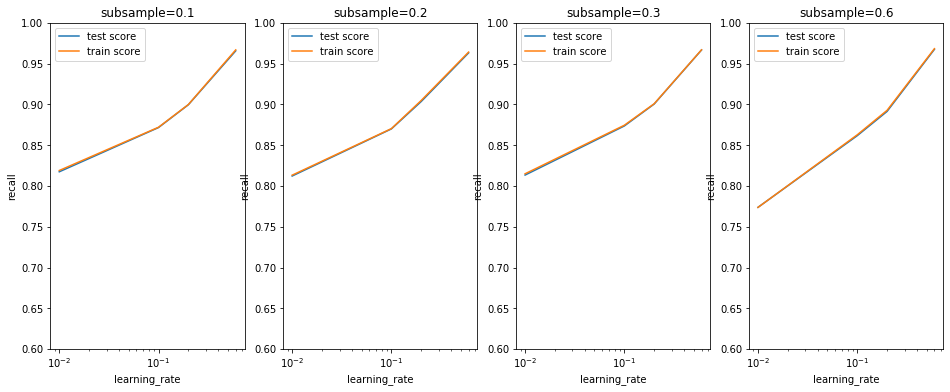

In [154]:
#plotting
plt.figure(figsize=(16,6))
param_grid = {'learning_rate': [0.001,0.01,0.1,0.2,0.6], 
             'subsample': [0.1,0.2, 0.3,0.6]}  
for n, subsample in enumerate(param_grid['subsample']):
    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('recall')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

Learning rate around 0.2 and subsample around 0.3 seems to be a good value.

### 6.5.2 XGBoost(ADASYN oversampling) Tuned

In [271]:
params = {'learning_rate': 0.2,
          'max_depth': 4, 
          'n_estimators':100,
          'subsample':0.3,
         }
# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train_ada_sampled,y_train_ada_sampled)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100,
                      'subsample': 0.3},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [272]:
# predict
y_train_ada_pred_xgb = model.predict(X_train_ada_sampled)

In [273]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_train_ada_sampled, y_train_ada_pred_xgb)
XGB_cm = confusion_matrix(y_train_ada_sampled, y_train_ada_pred_xgb)
XGB_auc = roc_auc_score(y_train_ada_sampled, y_train_ada_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_train_ada_sampled, y_train_ada_pred_xgb))

ROC AUC: 100.0000%
Accuracy: 100.0000%
Sensitivity/Recall 1.0
Specificity 1.0
Precision 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       1.00      1.00      1.00     50000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



In [274]:
# predict
y_test_ada_pred_xgb = model.predict(X_test)

In [275]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
import seaborn as sns
from matplotlib import pyplot

XGB_accuracy = accuracy_score(y_test, y_test_ada_pred_xgb)
XGB_cm = confusion_matrix(y_test, y_test_ada_pred_xgb)
XGB_auc = roc_auc_score(y_test, y_test_ada_pred_xgb)

print("ROC AUC: {:.4%}".format(XGB_auc))
print("Accuracy: {:.4%}".format(XGB_accuracy))
TP = XGB_cm[1,1] # true positive 
TN = XGB_cm[0,0] # true negatives
FP = XGB_cm[0,1] # false positives
FN = XGB_cm[1,0] # false negatives

#Sensitivity
print('Sensitivity/Recall',TP / float(TP+FN))

#Specificity
print('Specificity',TN / float(TN+FP))

#Precision
print('Precision',TP / float(TP+FP))
# Printing classification report
print(classification_report(y_test, y_test_ada_pred_xgb))

ROC AUC: 94.3016%
Accuracy: 99.8086%
Sensitivity/Recall 0.8877551020408163
Specificity 0.9982765291407266
Precision 0.4702702702702703
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.47      0.89      0.61        98

    accuracy                           1.00     56960
   macro avg       0.74      0.94      0.81     56960
weighted avg       1.00      1.00      1.00     56960



#### feature importance

In [276]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'V1': 0.027382754,
 'V2': 0.046806578,
 'V3': 0.018857753,
 'V4': 0.2701623,
 'V5': 0.018864783,
 'V6': 0.01933325,
 'V7': 0.047795776,
 'V8': 0.071568914,
 'V9': 0.023489181,
 'V10': 0.022175899,
 'V11': 0.037530415,
 'V12': 0.019936599,
 'V13': 0.018531935,
 'V14': 0.12570587,
 'V15': 0.01085422,
 'V16': 0.012197488,
 'V17': 0.024629928,
 'V18': 0.025075046,
 'V19': 0.017815523,
 'V20': 0.011001739,
 'V21': 0.011910042,
 'V22': 0.013274193,
 'V23': 0.02275285,
 'V24': 0.013897917,
 'V25': 0.012406066,
 'V26': 0.016404761,
 'V27': 0.010624106,
 'V28': 0.01318693,
 'Amount': 0.015827052}

V4 and V14 are having the highest coeffcient and seems to be most important features.

### 7.1. Model Evaluation on balanced data Adasyn

Below is the metric on training data results we can evaluate our model on

Model$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Precision$\;\;\;$ Recall$\;\;\;$ Accuracy$\;\;\;$ ROC_AUC

Logistic(Tuned:Ridge)$\;\;\;\;\;\;\;$    0.90 $\;\;\;$	0.86 $\;\;\;$	0.88  $\;\;\;\;\;\;\;\;\;$    0.88<br>
Logistic(Tuned:Ridge)$\;\;\;\;\;\;\;$    0.01 $\;\;\;$	0.96 $\;\;\;$	0.90  $\;\;\;\;\;\;\;\;\;$    0.93<br>

KNN (Tuned,K = 5)$\;\;\;\;\;\;\;$	     0.99 $\;\;\;$	1.0 $\;\;\;$	0.99  $\;\;\;\;\;\;\;\;\;$    0.99<br>
KNN (Tuned,K = 5)$\;\;\;\;\;\;\;$	     0.17 $\;\;\;$	0.83 $\;\;\;$	0.91  $\;\;\;\;\;\;\;\;\;$    0.99<br>

DecisionTree(Tuned)$\;\;\;\;\;\;$        0.97 $\;\;\;$	0.99 $\;\;\;$	0.98  $\;\;\;\;\;\;\;\;\;$    0.98<br>
 
Random Forest(Tuned)$\;\;\;\;\;\;$       0.96 $\;\;\;$	0.96 $\;\;\;$	0.96  $\;\;\;\;\;\;\;\;\;$    0.96<br>
Random Forest(Tuned)$\;\;\;\;\;\;$       0.04 $\;\;\;$	0.89 $\;\;\;$	0.96  $\;\;\;\;\;\;\;\;\;$    0.93<br>

XGBOOST	  (Tuned)$\;\;\;\;\;\;\;$        1.0 $\;\;\;$	1.0 $\;\;\;$	1.00  $\;\;\;\;\;\;\;\;\;$    1.00<br>(Overfitting)
XGBOOST	  (Tuned)$\;\;\;\;\;\;\;$        0.47 $\;\;\;$	0.88 $\;\;\;$	0.99  $\;\;\;\;\;\;\;\;\;$    0.43<br>  


#### From the above result, we can say that All the models are performing good on training data but are giving very less precision the test data. where as XGBoost is giving a little better precision in comparison.



### 7.2 Model Evaluation on balanced data SMOTE

Below is the metric on train and test data results we can evaluate our model on

Model$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Precision$\;\;\;$ Recall$\;\;\;$ Accuracy$\;\;\;$ ROC_AUC

Logistic(Tuned:Ridge)$\;\;\;\;\;$    0.97 $\;\;\;$	0.91 $\;\;\;$	0.94  $\;\;\;\;\;\;\;\;\;$    0.94<br>
Logistic(Tuned:Ridge)$\;\;\;\;\;$    0.05 $\;\;\;$	0.91 $\;\;\;$	0.97  $\;\;\;\;\;\;\;\;\;$    0.94<br>

KNN (Tuned,K = 5)$\;\;\;\;\;\;\;$	     0.99 $\;\;\;$	1.0 $\;\;\;$	0.99  $\;\;\;\;\;\;\;\;\;$    0.99<br> 
KNN (Tuned,K = 5)$\;\;\;\;\;\;\;$	     0.48 $\;\;\;$	0.82 $\;\;\;$	0.91  $\;\;\;\;\;\;\;\;\;$    0.99<br>  

DecisionTree(Tuned)$\;\;\;\;\;\;$        0.98 $\;\;\;$	0.98 $\;\;\;$	0.98  $\;\;\;\;\;\;\;\;\;$    0.98<br>
DecisionTree(Tuned)$\;\;\;\;\;\;$        0.09 $\;\;\;$	0.81 $\;\;\;$	0.98  $\;\;\;\;\;\;\;\;\;$    0.90<br>
 
Random Forest(Tuned)$\;\;\;\;$       0.99 $\;\;\;$	0.94 $\;\;\;$	0.96  $\;\;\;\;\;\;\;\;\;$    0.96<br>
Random Forest(Tuned)$\;\;\;\;$       0.28 $\;\;\;$	0.85 $\;\;\;$	0.99  $\;\;\;\;\;\;\;\;\;$    0.92<br>

XGBOOST	  (Tuned)$\;\;\;\;\;\;\;$        1.0 $\;\;\;$	1.0 $\;\;\;$	1.00  $\;\;\;\;\;\;\;\;\;$    1.00<br>   
XGBOOST	  (Tuned)$\;\;\;\;\;\;\;$        0.76 $\;\;\;$	0.82 $\;\;\;$	0.99  $\;\;\;\;\;\;\;\;\;$    0.91<br>


#### From the above result, we can say that All the models are performing good on training data. KNN and XGBOOST are almost overfitting the training data, where as XGBoost is giving a little better and highest precision in comparison.

### Recommandation:
#### SMOTE with XGBOOST is giving best results on the test data.